# NOTEBOOK D'ENTRAÎNEMENT D'UN SNN AVEC UN CNN PRÉ-ENTRAÎNÉ SUR FER2013

# 1. IMPORTS ET CONFIGURATION

In [ ]:

import numpy as np
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, WeightedRandomSampler
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import time
import os
from tqdm import tqdm
import warnings
import json
from datetime import datetime

# Configuration warnings
warnings.filterwarnings('ignore')

# Fix numpy compatibility
np.int = int

# Configuration matplotlib
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

print(" SIMPLE SNN TRAINING NOTEBOOK")
print("=" * 50)
print(f" Démarré le: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print("=" * 50)

 SIMPLE SNN TRAINING NOTEBOOK
 Démarré le: 2025-08-24 00:54:41


In [3]:
# =============================================================================
# CONFIGURATION GPU ET MONITORING ÉNERGÉTIQUE  
# =============================================================================

# Configuration GPU et monitoring énergétique avec PyNVML
try:
    import pynvml
    pynvml.nvmlInit()
    gpu_handle = pynvml.nvmlDeviceGetHandleByIndex(0)
    gpu_monitoring = True
    
    def get_gpu_power_usage():
        """Retourne la consommation GPU actuelle en watts"""
        return pynvml.nvmlDeviceGetPowerUsage(gpu_handle) / 1000  # Conversion mW -> W
    
    def get_gpu_memory_usage():
        """Retourne l'utilisation mémoire GPU en GB"""
        info = pynvml.nvmlDeviceGetMemoryInfo(gpu_handle)
        return info.used / 1024**3  # Conversion bytes -> GB
    
    def get_gpu_info():
        """Affiche les informations GPU"""
        # Correction : gestion du nom GPU pour toutes les versions de PyNVML
        gpu_name_raw = pynvml.nvmlDeviceGetName(gpu_handle)
        if isinstance(gpu_name_raw, bytes):
            name = gpu_name_raw.decode('utf-8')
        else:
            name = gpu_name_raw  # Déjà une string dans les versions récentes
            
        power_limit = pynvml.nvmlDeviceGetPowerManagementLimitConstraints(gpu_handle)[1] / 1000
        memory_info = pynvml.nvmlDeviceGetMemoryInfo(gpu_handle)
        total_memory = memory_info.total / 1024**3
        
        print(f" GPU détecté: {name}")
        print(f" Limite de puissance: {power_limit:.0f}W")
        print(f" Mémoire totale: {total_memory:.1f}GB")
        return name, power_limit, total_memory
    
    # Affichage des informations GPU
    gpu_name, power_limit, total_memory = get_gpu_info()
    print(" Monitoring énergétique activé avec PyNVML")
    
except ImportError:
    print("  PyNVML non disponible, monitoring énergétique désactivé")
    print("   Installation: pip install nvidia-ml-py3")
    gpu_monitoring = False
    
    def get_gpu_power_usage():
        return 0
    
    def get_gpu_memory_usage():
        return 0
        
except Exception as e:
    print(f"  Erreur PyNVML: {e}")
    print("   Le monitoring énergétique sera désactivé")
    gpu_monitoring = False
    
    def get_gpu_power_usage():
        return 0
    
    def get_gpu_memory_usage():
        return 0

 GPU détecté: NVIDIA GeForce RTX 3050 6GB Laptop GPU
 Limite de puissance: 95W
 Mémoire totale: 6.0GB
 Monitoring énergétique activé avec PyNVML


In [ ]:
# =============================================================================  
# 2. IMPORT DES MODÈLES ET TEST INITIAL
# =============================================================================

import torch
import traceback

# Import des modèles créés
try:
    print(" Import du module snn_simple...")
    
    from snn_model import (
        create_simple_snn,
        create_baseline_ann, 
        reset_snn_state,
        test_models,
        get_model_info
    )
    print(" Modèles importés avec succès")
    
    # Vérification des versions
    print(f"   PyTorch version: {torch.__version__}")
    print(f"   CUDA disponible: {torch.cuda.is_available()}")
    if torch.cuda.is_available():
        print(f"   GPU actuel: {torch.cuda.get_device_name()}")
    
    # Test rapide des modèles avec diagnostic détaillé
    print("\n Test des modèles...")
    
    try:
        models_ok = test_models()
        
        if models_ok:
            print(" Tous les modèles fonctionnent correctement")
            
            # Test supplémentaire pour s'assurer que tout fonctionne
            print("\n Test supplémentaire de création des modèles...")
            
            # Création et test rapide des modèles
            snn_model = create_simple_snn("simple", num_classes=7, num_timesteps=8)
            ann_model = create_baseline_ann(num_classes=7)
            
            # Test avec un petit batch
            test_batch = torch.randn(2, 1, 48, 48)
            with torch.no_grad():
                snn_out = snn_model(test_batch)
                ann_out = ann_model(test_batch)
                
            print(f"   SNN output shape: {snn_out.shape}")
            print(f"   ANN output shape: {ann_out.shape}")
            print("    Test supplémentaire réussi")
            
        else:
            print(" Problème détecté dans test_models()")
            
            # Diagnostic manuel en cas d'échec
            print("\n Diagnostic manuel...")
            
            try:
                # Test de création simple
                print("   - Test création SNN ultra-simple...")
                ultra_model = create_simple_snn("ultra_simple", num_classes=7, num_timesteps=4)
                
                test_input = torch.randn(1, 1, 48, 48)
                with torch.no_grad():
                    output = ultra_model(test_input)
                    
                print(f"     Input: {test_input.shape}")
                print(f"     Output: {output.shape}")
                
                if output.shape == (1, 7):
                    print("  Test manuel réussi - les modèles fonctionnent")
                    models_ok = True
                else:
                    print(f" Shape incorrecte: attendu (1, 7), obtenu {output.shape}")
                    
            except Exception as manual_error:
                print(f"  Erreur lors du test manuel: {manual_error}")
                traceback.print_exc()
        
        if not models_ok:
            print("\n Les modèles ne passent pas les tests")
            print("\n Solutions possibles:")
            print("   1. Redémarrer le kernel/environnement Python")
            print("   2. Vérifier l'installation de SpikingJelly:")
            print("      pip install spikingjelly")
            print("   3. Vérifier la compatibilité PyTorch-SpikingJelly")
            print("   4. Essayer avec des paramètres plus conservateurs")
            
            user_choice = input("\n Voulez-vous continuer malgré l'erreur ? (y/n): ")
            if user_choice.lower() != 'y':
                raise Exception("Tests des modèles échoués - arrêt demandé par l'utilisateur")
            else:
                print("  Continuation forcée - attention aux résultats suivants")
            
    except KeyboardInterrupt:
        print("\n Test interrompu par l'utilisateur")
        raise
        
    except Exception as test_error:
        print(f"\n Erreur lors des tests: {test_error}")
        print("\n Traceback complet:")
        traceback.print_exc()
        
        print("\n Informations de debug:")
        print(f"   - Python executable: {__import__('sys').executable}")
        print(f"   - Working directory: {__import__('os').getcwd()}")
        
        # Vérification de l'existence du fichier
        import os
        if os.path.exists('snn_simple.py'):
            print("   - snn_simple.py trouvé ")
        else:
            print("   - snn_simple.py MANQUANT ")
            
        raise Exception(f"Erreur dans les tests des modèles: {test_error}")
        
except ImportError as e:
    print(f" Erreur d'import: {e}")
    print("\n Solutions:")
    print("   1. Vérifiez que snn_simple.py est dans le même dossier")
    print("   2. Vérifiez que le fichier snn_simple.py est complet")
    print("   3. Vérifiez l'installation de SpikingJelly:")
    print("      pip install spikingjelly")
    print("   4. Redémarrez le kernel")
    
    # Affichage du contenu du dossier pour diagnostic
    import os
    print(f"\n Contenu du dossier actuel:")
    try:
        for file in os.listdir('.'):
            if file.endswith('.py'):
                print(f"   - {file} ")
            else:
                print(f"   - {file}")
    except Exception:
        print("   Erreur lors de la lecture du dossier")
    
    raise

except Exception as e:
    print(f" Erreur inattendue: {e}")
    print("\n Traceback complet:")
    traceback.print_exc()
    raise

print("\n Import et tests terminés avec succès!")
print("    Les modèles sont prêts pour l'entraînement")

 Import du module snn_simple...
 Modèles importés avec succès
   PyTorch version: 2.5.1
   CUDA disponible: True
   GPU actuel: NVIDIA GeForce RTX 3050 6GB Laptop GPU

 Test des modèles...
🔍 Test de fonctionnement des modèles...

    Test ANN Baseline:
🔧 Création du modèle ANN baseline...
✅ Modèle ANN baseline créé
   Paramètres totaux: 102,119
   Paramètres entraînables: 102,119
   Classes: 7
      Input: torch.Size([4, 1, 48, 48]) -> Output: torch.Size([4, 7])
      ANN test réussi

    Test Ultra Simple SNN:
🔧 Création du modèle SNN (ultra_simple)...
 Modèle SNN créé avec succès
   Architecture: ultra_simple
   Paramètres totaux: 5,216
   Paramètres entraînables: 5,216
   Classes: 7
   Pas temporels: 6
   ⚡ Paramètres tau: tous > 1.0 (SpikingJelly compatible)
      Input: torch.Size([4, 1, 48, 48]) -> Output: torch.Size([4, 7])
      Ultra SNN test réussi

    Test Simple SNN:
🔧 Création du modèle SNN (simple)...
 Modèle SNN créé avec succès
   Architecture: simple
   Paramètres tot

In [5]:
# =============================================================================
# 3. CONFIGURATION 
# =============================================================================

class Config:
    """Configuration centralisée pour l'expérience"""
    
    def __init__(self):
        # =====================================================================
        # PARAMÈTRES DATASET
        # =====================================================================
        # 🔧 CHANGEZ CE CHEMIN VERS VOTRE DATASET
        self.dataset_path = "/home/dieudo/Projects/Project_Neuro/Fer_Neuromorphique/data"
        self.num_classes = 7
        
        # =====================================================================
        # PARAMÈTRES MODÈLES
        # =====================================================================
        self.snn_architecture = "simple"  # "simple" ou "ultra_simple"
        self.snn_timesteps = 8             # Nombre de pas temporels
        
        # =====================================================================  
        # PARAMÈTRES ENTRAÎNEMENT
        # =====================================================================
        self.epochs = 50                   # Assez pour voir les tendances
        self.batch_size = 32               # Stable pour les deux modèles
        
        # Learning rates différenciés
        self.ann_lr = 1e-3                 # Plus haut pour ANN
        self.snn_lr = 5e-4                 # Plus bas pour SNN
        self.weight_decay = 1e-4
        
        # =====================================================================
        # PARAMÈTRES ÉVALUATION
        # =====================================================================
        self.patience = 8                  # Early stopping
        self.save_best_models = True
        
        # =====================================================================
        # CHEMINS DE SORTIE
        # =====================================================================
        self.results_dir = "simple_snn_results"
        self.timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        self.experiment_dir = f"{self.results_dir}/{self.timestamp}"

# Initialisation de la configuration
config = Config()

# Création des dossiers de résultats
os.makedirs(config.experiment_dir, exist_ok=True)
print(f" Dossier de résultats: {config.experiment_dir}")

# Sauvegarde de la configuration
config_dict = {k: v for k, v in vars(config).items() if not k.startswith('_')}
with open(f"{config.experiment_dir}/config.json", 'w') as f:
    json.dump(config_dict, f, indent=2, default=str)

print(" Configuration sauvegardée")

 Dossier de résultats: simple_snn_results/20250824_005442
 Configuration sauvegardée


In [6]:
# =============================================================================
# 4. CHARGEMENT ET ANALYSE DES DONNÉES
# =============================================================================

print("\n" + "=" * 50)
print(" CHARGEMENT ET ANALYSE DES DONNÉES")
print("=" * 50)

# Device setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"  Device utilisé: {device}")

# Transformations simples et robustes
transform_train = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((52, 52)),                    # Légèrement plus grand
    transforms.RandomCrop(48, padding=2),           # Crop avec padding minimal
    transforms.RandomHorizontalFlip(p=0.3),         # Flip occasionnel
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))            # Normalisation simple
])

transform_test = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((48, 48)),                     # Taille exacte pour test
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Chargement des datasets
try:
    print(f" Chargement depuis: {config.dataset_path}")
    
    train_dataset = ImageFolder(
        root=f"{config.dataset_path}/train", 
        transform=transform_train
    )
    
    test_dataset = ImageFolder(
        root=f"{config.dataset_path}/test", 
        transform=transform_test
    )
    
    print(f" Train dataset: {len(train_dataset)} images")
    print(f" Test dataset: {len(test_dataset)} images") 
    print(f" Classes: {train_dataset.classes}")
    
    # Vérification cohérence
    assert len(train_dataset.classes) == config.num_classes, f"Nombre de classes incorrect: {len(train_dataset.classes)} vs {config.num_classes}"
    
except Exception as e:
    print(f" Erreur chargement dataset: {e}")
    print(" Vérifiez le chemin dans la Config (cellule précédente)")
    raise

# Analyse de la distribution des classes
print("\n Analyse de la distribution des classes:")
class_counts = Counter([label for _, label in train_dataset.samples])
total_images = sum(class_counts.values())

print("Distribution train:")
for i, (class_name, count) in enumerate(zip(train_dataset.classes, [class_counts[i] for i in range(len(train_dataset.classes))])):
    percentage = 100 * count / total_images
    print(f"  {class_name:12}: {count:5d} images ({percentage:5.1f}%)")

# Calcul du déséquilibre
min_count = min(class_counts.values())
max_count = max(class_counts.values())
imbalance_ratio = max_count / min_count

print(f"\n Ratio de déséquilibre: {imbalance_ratio:.1f}:1")

if imbalance_ratio > 10:
    print(" DÉSÉQUILIBRE SÉVÈRE détecté - ceci peut expliquer les mauvaises performances !")
elif imbalance_ratio > 3:
    print("  Déséquilibre modéré détecté - équilibrage recommandé")
else:
    print(" Distribution relativement équilibrée")


 CHARGEMENT ET ANALYSE DES DONNÉES
  Device utilisé: cuda
 Chargement depuis: /home/dieudo/Projects/Project_Neuro/Fer_Neuromorphique/data
 Train dataset: 28709 images
 Test dataset: 7178 images
 Classes: ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

 Analyse de la distribution des classes:
Distribution train:
  angry       :  3995 images ( 13.9%)
  disgust     :   436 images (  1.5%)
  fear        :  4097 images ( 14.3%)
  happy       :  7215 images ( 25.1%)
  neutral     :  4965 images ( 17.3%)
  sad         :  4830 images ( 16.8%)
  surprise    :  3171 images ( 11.0%)

 Ratio de déséquilibre: 16.5:1
 DÉSÉQUILIBRE SÉVÈRE détecté - ceci peut expliquer les mauvaises performances !


In [7]:
# =============================================================================
# 5. CRÉATION DES DATALOADERS
# =============================================================================

print("\n Création des DataLoaders...")

# Équilibrage des classes si nécessaire
if imbalance_ratio > 2.5:
    print("🔧 Application de l'équilibrage des classes...")
    
    # Calcul des poids pour équilibrage
    class_weights = {cls: 1.0 / count for cls, count in class_counts.items()}
    sample_weights = [class_weights[label] for _, label in train_dataset.samples]
    
    # Sampler avec équilibrage
    sampler = WeightedRandomSampler(
        sample_weights, 
        num_samples=len(sample_weights),
        replacement=True
    )
    
    shuffle = False  # Pas de shuffle avec sampler
    print(" Équilibrage appliqué")
else:
    sampler = None
    shuffle = True
    print(" Pas d'équilibrage nécessaire")

# Création des DataLoaders
train_loader = DataLoader(
    train_dataset,
    batch_size=config.batch_size,
    shuffle=shuffle,
    sampler=sampler,
    num_workers=4,
    pin_memory=True,
    drop_last=True  # Pour éviter les petits derniers batches
)

test_loader = DataLoader(
    test_dataset,
    batch_size=config.batch_size,
    shuffle=False,
    num_workers=4,
    pin_memory=True,
    drop_last=False
)

print(f" Train DataLoader: {len(train_loader)} batches")
print(f" Test DataLoader: {len(test_loader)} batches")

# Test d'un batch pour vérification
try:
    sample_batch = next(iter(train_loader))
    sample_images, sample_labels = sample_batch
    print(f" Batch de test: images {sample_images.shape}, labels {sample_labels.shape}")
    
    # Vérification de la distribution dans un batch
    sample_class_dist = Counter(sample_labels.numpy())
    print(f"   Distribution du batch échantillon: {dict(sample_class_dist)}")
    
except Exception as e:
    print(f" Erreur test DataLoader: {e}")
    raise


 Création des DataLoaders...
🔧 Application de l'équilibrage des classes...
 Équilibrage appliqué
 Train DataLoader: 897 batches
 Test DataLoader: 225 batches
 Batch de test: images torch.Size([32, 1, 48, 48]), labels torch.Size([32])
   Distribution du batch échantillon: {0: 4, 1: 9, 6: 1, 5: 5, 4: 5, 3: 4, 2: 4}


In [8]:
# =============================================================================
# 6. FONCTIONS D'ENTRAÎNEMENT
# =============================================================================

def train_model(model, model_name, train_loader, test_loader, config, device):
    """
    Fonction d'entraînement unifiée pour ANN et SNN avec monitoring énergétique
    
    Args:
        model: Le modèle à entraîner
        model_name: "ANN" ou "SNN" pour différencier
        train_loader, test_loader: DataLoaders
        config: Configuration
        device: Device PyTorch
    
    Returns:
        dict: Historique d'entraînement et métriques avec données énergétiques
    """
    
    print(f"\n ENTRAÎNEMENT {model_name}")
    print("-" * 30)
    
    # Configuration optimiseur selon le type de modèle
    if model_name == "ANN":
        optimizer = torch.optim.Adam(
            model.parameters(),
            lr=config.ann_lr,
            weight_decay=config.weight_decay
        )
    else:  # SNN
        optimizer = torch.optim.Adam(
            model.parameters(),
            lr=config.snn_lr,
            weight_decay=config.weight_decay
        )
    
    # Scheduler cosine annealing
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer,
        T_max=config.epochs,
        eta_min=1e-6
    )
    
    criterion = nn.CrossEntropyLoss()
    
    # Variables pour tracking (avec énergie)
    history = {
        'train_losses': [],
        'train_accs': [],
        'val_losses': [],
        'val_accs': [],
        'learning_rates': [],
        'power_usage': [],      # Nouvelle métrique énergétique
        'memory_usage': []      # Nouvelle métrique mémoire
    }
    
    best_val_acc = 0.0
    best_epoch = 0
    patience_counter = 0
    
    # Boucle d'entraînement
    for epoch in range(config.epochs):
        epoch_start = time.time()
        
        # Monitoring énergétique - début d'époque
        power_start = get_gpu_power_usage() if gpu_monitoring else 0
        memory_start = get_gpu_memory_usage() if gpu_monitoring else 0
        
        # =================================================================
        # PHASE D'ENTRAÎNEMENT
        # =================================================================
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0
        
        # Monitoring énergétique durant l'entraînement
        epoch_power_samples = []
        
        # Progress bar pour l'entraînement
        train_pbar = tqdm(
            train_loader, 
            desc=f"{model_name} Epoch {epoch+1:2d} [Train]",
            leave=False
        )
        
        for batch_idx, (data, target) in enumerate(train_pbar):
            data, target = data.to(device, non_blocking=True), target.to(device, non_blocking=True)
            
            # Échantillonnage énergétique (tous les 20 batches)
            if batch_idx % 20 == 0 and gpu_monitoring:
                current_power = get_gpu_power_usage()
                epoch_power_samples.append(current_power)
            
            # Reset gradients
            optimizer.zero_grad()
            
            try:
                # Forward pass
                output = model(data)
                loss = criterion(output, target)
                
                # Backward pass
                loss.backward()
                
                # Gradient clipping pour la stabilité
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                
                # Optimizer step
                optimizer.step()
                
                # Statistiques
                train_loss += loss.item()
                pred = output.argmax(dim=1)
                train_correct += (pred == target).sum().item()
                train_total += target.size(0)
                
                # Reset SNN state si nécessaire
                if model_name == "SNN":
                    reset_snn_state(model)
                
                # Mise à jour progress bar avec énergie
                current_acc = train_correct / train_total
                if gpu_monitoring and len(epoch_power_samples) > 0:
                    avg_power = sum(epoch_power_samples) / len(epoch_power_samples)
                    train_pbar.set_postfix({
                        'Loss': f'{loss.item():.4f}',
                        'Acc': f'{current_acc:.3f}',
                        'Power': f'{avg_power:.1f}W'
                    })
                else:
                    train_pbar.set_postfix({
                        'Loss': f'{loss.item():.4f}',
                        'Acc': f'{current_acc:.3f}'
                    })
                
            except Exception as e:
                print(f" Erreur batch {batch_idx}: {e}")
                continue
        
        # Moyennes d'entraînement
        avg_train_loss = train_loss / len(train_loader)
        train_accuracy = train_correct / train_total
        
        # =================================================================
        # PHASE DE VALIDATION
        # =================================================================
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        all_preds = []
        all_labels = []
        
        val_pbar = tqdm(
            test_loader,
            desc=f"{model_name} Epoch {epoch+1:2d} [Val]",
            leave=False
        )
        
        with torch.no_grad():
            for data, target in val_pbar:
                data, target = data.to(device, non_blocking=True), target.to(device, non_blocking=True)
                
                try:
                    # Forward pass
                    output = model(data)
                    loss = criterion(output, target)
                    
                    # Statistiques
                    val_loss += loss.item()
                    pred = output.argmax(dim=1)
                    val_correct += (pred == target).sum().item()
                    val_total += target.size(0)
                    
                    # Collecte pour métriques détaillées
                    all_preds.extend(pred.cpu().numpy())
                    all_labels.extend(target.cpu().numpy())
                    
                    # Reset SNN state si nécessaire
                    if model_name == "SNN":
                        reset_snn_state(model)
                    
                    # Mise à jour progress bar
                    current_acc = val_correct / val_total
                    val_pbar.set_postfix({
                        'Loss': f'{loss.item():.4f}',
                        'Acc': f'{current_acc:.3f}'
                    })
                    
                except Exception as e:
                    print(f" Erreur validation: {e}")
                    continue
        
        # Moyennes de validation
        avg_val_loss = val_loss / len(test_loader)
        val_accuracy = val_correct / val_total
        
        # F1 score
        try:
            val_f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=0)
        except:
            val_f1 = 0.0
        
        # Monitoring énergétique - fin d'époque
        power_end = get_gpu_power_usage() if gpu_monitoring else 0
        memory_end = get_gpu_memory_usage() if gpu_monitoring else 0
        
        # Calcul des métriques énergétiques
        if gpu_monitoring and len(epoch_power_samples) > 0:
            avg_epoch_power = sum(epoch_power_samples) / len(epoch_power_samples)
            avg_epoch_memory = (memory_start + memory_end) / 2
        else:
            avg_epoch_power = 0
            avg_epoch_memory = 0
        
        # Mise à jour du scheduler
        scheduler.step()
        current_lr = optimizer.param_groups[0]['lr']
        
        # Stockage historique (avec métriques énergétiques)
        history['train_losses'].append(avg_train_loss)
        history['train_accs'].append(train_accuracy)
        history['val_losses'].append(avg_val_loss)
        history['val_accs'].append(val_accuracy)
        history['learning_rates'].append(current_lr)
        history['power_usage'].append(avg_epoch_power)
        history['memory_usage'].append(avg_epoch_memory)
        
        # Temps d'époque
        epoch_time = time.time() - epoch_start
        
        # Affichage des résultats (avec énergie si disponible)
        if gpu_monitoring:
            print(f"{model_name} Epoch {epoch+1:2d}: "
                  f"Train Loss: {avg_train_loss:.4f}, Train Acc: {train_accuracy:.3f} ({train_accuracy*100:.1f}%) | "
                  f"Val Loss: {avg_val_loss:.4f}, Val Acc: {val_accuracy:.3f} ({val_accuracy*100:.1f}%), "
                  f"F1: {val_f1:.3f} | ⚡{avg_epoch_power:.1f}W {avg_epoch_memory:.1f}GB | {epoch_time:.1f}s")
        else:
            print(f"{model_name} Epoch {epoch+1:2d}: "
                  f"Train Loss: {avg_train_loss:.4f}, Train Acc: {train_accuracy:.3f} ({train_accuracy*100:.1f}%) | "
                  f"Val Loss: {avg_val_loss:.4f}, Val Acc: {val_accuracy:.3f} ({val_accuracy*100:.1f}%), "
                  f"F1: {val_f1:.3f} | {epoch_time:.1f}s")
        
        # Sauvegarde du meilleur modèle
        if val_accuracy > best_val_acc:
            best_val_acc = val_accuracy
            best_epoch = epoch
            patience_counter = 0
            
            if config.save_best_models:
                model_path = f"{config.experiment_dir}/best_{model_name.lower()}_model.pth"
                torch.save({
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'best_val_acc': best_val_acc,
                    'model_name': model_name
                }, model_path)
                print(f" Meilleur modèle sauvegardé: {best_val_acc:.3f}")
        else:
            patience_counter += 1
        
        # Early stopping
        if patience_counter >= config.patience:
            print(f" Early stopping après {epoch+1} epochs (patience: {config.patience})")
            break
        
        # Alerte pour SNN qui apprend très lentement
        if model_name == "SNN" and epoch >= 5 and best_val_acc < 0.15:
            print(f" SNN apprend très lentement - possibles problèmes d'architecture")
    
    # Résumé final avec métriques énergétiques
    print(f"\n {model_name} - Entraînement terminé:")
    print(f"    Meilleure accuracy: {best_val_acc:.3f} ({best_val_acc*100:.1f}%) à l'époque {best_epoch+1}")
    
    if gpu_monitoring:
        avg_power = sum(history['power_usage']) / len(history['power_usage']) if history['power_usage'] else 0
        max_power = max(history['power_usage']) if history['power_usage'] else 0
        avg_memory = sum(history['memory_usage']) / len(history['memory_usage']) if history['memory_usage'] else 0
        
        print(f"    ⚡ Consommation moyenne: {avg_power:.1f}W (max: {max_power:.1f}W)")
        print(f"   Mémoire moyenne: {avg_memory:.1f}GB")
    
    # Ajout des métriques finales
    history.update({
        'best_val_acc': best_val_acc,
        'best_epoch': best_epoch,
        'final_preds': all_preds,
        'final_labels': all_labels,
        'model_info': get_model_info(model),
        'avg_power': sum(history['power_usage']) / len(history['power_usage']) if history['power_usage'] else 0,
        'max_power': max(history['power_usage']) if history['power_usage'] else 0,
        'avg_memory': sum(history['memory_usage']) / len(history['memory_usage']) if history['memory_usage'] else 0
    })
    
    return history

In [9]:
# =============================================================================
# 7. ENTRAÎNEMENT DU BASELINE ANN
# =============================================================================

print("\n" + "=" * 50)
print(" ENTRAÎNEMENT ANN BASELINE")
print("=" * 50)
print("L'ANN baseline va nous indiquer si les données sont exploitables...")

# Création du modèle ANN
ann_model = create_baseline_ann(num_classes=config.num_classes)
ann_model = ann_model.to(device)

print(f" ANN créé avec {get_model_info(ann_model)['total_params']:,} paramètres")

# Entraînement
ann_results = train_model(
    model=ann_model,
    model_name="ANN",
    train_loader=train_loader,
    test_loader=test_loader,
    config=config,
    device=device
)


 ENTRAÎNEMENT ANN BASELINE
L'ANN baseline va nous indiquer si les données sont exploitables...
🔧 Création du modèle ANN baseline...
✅ Modèle ANN baseline créé
   Paramètres totaux: 102,119
   Paramètres entraînables: 102,119
   Classes: 7
 ANN créé avec 102,119 paramètres

 ENTRAÎNEMENT ANN
------------------------------


ANN Epoch  1: Train Loss: 1.9012, Train Acc: 0.208 (20.8%) | Val Loss: 1.8625, Val Acc: 0.219 (21.9%), F1: 0.184 | ⚡16.2W 1.1GB | 8.7s
 Meilleur modèle sauvegardé: 0.219


ANN Epoch  2: Train Loss: 1.8404, Train Acc: 0.253 (25.3%) | Val Loss: 1.8046, Val Acc: 0.277 (27.7%), F1: 0.265 | ⚡16.8W 1.2GB | 7.6s
 Meilleur modèle sauvegardé: 0.277


ANN Epoch  3: Train Loss: 1.7669, Train Acc: 0.301 (30.1%) | Val Loss: 1.7500, Val Acc: 0.289 (28.9%), F1: 0.291 | ⚡16.8W 1.2GB | 7.4s
 Meilleur modèle sauvegardé: 0.289


ANN Epoch  4: Train Loss: 1.7172, Train Acc: 0.328 (32.8%) | Val Loss: 1.7408, Val Acc: 0.313 (31.3%), F1: 0.310 | ⚡16.9W 1.1GB | 7.3s
 Meilleur modèle sauvegardé: 0.313


ANN Epoch  5: Train Loss: 1.6742, Train Acc: 0.345 (34.5%) | Val Loss: 1.6106, Val Acc: 0.375 (37.5%), F1: 0.362 | ⚡17.0W 1.1GB | 7.3s
 Meilleur modèle sauvegardé: 0.375


ANN Epoch  6: Train Loss: 1.6370, Train Acc: 0.368 (36.8%) | Val Loss: 1.6387, Val Acc: 0.365 (36.5%), F1: 0.335 | ⚡17.0W 1.1GB | 7.5s


ANN Epoch  7: Train Loss: 1.5970, Train Acc: 0.390 (39.0%) | Val Loss: 1.7000, Val Acc: 0.343 (34.3%), F1: 0.342 | ⚡17.2W 1.1GB | 7.3s


ANN Epoch  8: Train Loss: 1.5609, Train Acc: 0.399 (39.9%) | Val Loss: 1.5653, Val Acc: 0.398 (39.8%), F1: 0.390 | ⚡17.5W 1.1GB | 7.4s
 Meilleur modèle sauvegardé: 0.398


ANN Epoch  9: Train Loss: 1.5301, Train Acc: 0.410 (41.0%) | Val Loss: 1.5986, Val Acc: 0.390 (39.0%), F1: 0.392 | ⚡17.4W 1.1GB | 7.3s


ANN Epoch 10: Train Loss: 1.4965, Train Acc: 0.427 (42.7%) | Val Loss: 1.4991, Val Acc: 0.416 (41.6%), F1: 0.415 | ⚡16.2W 1.1GB | 13.1s
 Meilleur modèle sauvegardé: 0.416


ANN Epoch 11: Train Loss: 1.4742, Train Acc: 0.440 (44.0%) | Val Loss: 1.5914, Val Acc: 0.383 (38.3%), F1: 0.390 | ⚡15.0W 1.1GB | 16.9s


ANN Epoch 12: Train Loss: 1.4605, Train Acc: 0.442 (44.2%) | Val Loss: 1.4573, Val Acc: 0.436 (43.6%), F1: 0.426 | ⚡14.9W 1.1GB | 17.3s
 Meilleur modèle sauvegardé: 0.436


ANN Epoch 13: Train Loss: 1.4482, Train Acc: 0.441 (44.1%) | Val Loss: 1.4711, Val Acc: 0.441 (44.1%), F1: 0.425 | ⚡14.8W 1.1GB | 17.8s
 Meilleur modèle sauvegardé: 0.441


ANN Epoch 14: Train Loss: 1.4259, Train Acc: 0.456 (45.6%) | Val Loss: 1.4601, Val Acc: 0.442 (44.2%), F1: 0.428 | ⚡14.8W 1.1GB | 17.9s
 Meilleur modèle sauvegardé: 0.442


ANN Epoch 15: Train Loss: 1.4126, Train Acc: 0.463 (46.3%) | Val Loss: 1.4223, Val Acc: 0.446 (44.6%), F1: 0.431 | ⚡14.8W 1.1GB | 17.2s
 Meilleur modèle sauvegardé: 0.446


ANN Epoch 16: Train Loss: 1.3869, Train Acc: 0.476 (47.6%) | Val Loss: 1.5089, Val Acc: 0.413 (41.3%), F1: 0.417 | ⚡14.8W 1.1GB | 17.2s


ANN Epoch 17: Train Loss: 1.3795, Train Acc: 0.477 (47.7%) | Val Loss: 1.6318, Val Acc: 0.384 (38.4%), F1: 0.398 | ⚡14.8W 1.1GB | 16.8s


ANN Epoch 18: Train Loss: 1.3563, Train Acc: 0.483 (48.3%) | Val Loss: 1.4733, Val Acc: 0.437 (43.7%), F1: 0.443 | ⚡14.8W 1.1GB | 16.6s


ANN Epoch 19: Train Loss: 1.3557, Train Acc: 0.487 (48.7%) | Val Loss: 1.3566, Val Acc: 0.474 (47.4%), F1: 0.467 | ⚡16.0W 1.1GB | 7.3s
 Meilleur modèle sauvegardé: 0.474


ANN Epoch 20: Train Loss: 1.3336, Train Acc: 0.493 (49.3%) | Val Loss: 1.3378, Val Acc: 0.478 (47.8%), F1: 0.458 | ⚡16.1W 1.1GB | 7.3s
 Meilleur modèle sauvegardé: 0.478


ANN Epoch 21: Train Loss: 1.3243, Train Acc: 0.498 (49.8%) | Val Loss: 1.3497, Val Acc: 0.481 (48.1%), F1: 0.452 | ⚡16.0W 1.1GB | 7.4s
 Meilleur modèle sauvegardé: 0.481


ANN Epoch 22: Train Loss: 1.3049, Train Acc: 0.508 (50.8%) | Val Loss: 1.4450, Val Acc: 0.457 (45.7%), F1: 0.470 | ⚡16.0W 1.1GB | 7.3s


ANN Epoch 23: Train Loss: 1.2914, Train Acc: 0.515 (51.5%) | Val Loss: 1.3464, Val Acc: 0.480 (48.0%), F1: 0.467 | ⚡16.1W 1.1GB | 7.3s


ANN Epoch 24: Train Loss: 1.2944, Train Acc: 0.512 (51.2%) | Val Loss: 1.4663, Val Acc: 0.434 (43.4%), F1: 0.453 | ⚡16.1W 1.1GB | 7.3s


ANN Epoch 25: Train Loss: 1.2746, Train Acc: 0.516 (51.6%) | Val Loss: 1.3936, Val Acc: 0.464 (46.4%), F1: 0.455 | ⚡16.1W 1.1GB | 7.4s


ANN Epoch 26: Train Loss: 1.2643, Train Acc: 0.525 (52.5%) | Val Loss: 1.3247, Val Acc: 0.494 (49.4%), F1: 0.475 | ⚡16.3W 1.1GB | 7.4s
 Meilleur modèle sauvegardé: 0.494


ANN Epoch 27: Train Loss: 1.2580, Train Acc: 0.521 (52.1%) | Val Loss: 1.3064, Val Acc: 0.493 (49.3%), F1: 0.482 | ⚡16.5W 1.1GB | 7.4s


ANN Epoch 28: Train Loss: 1.2411, Train Acc: 0.530 (53.0%) | Val Loss: 1.2937, Val Acc: 0.497 (49.7%), F1: 0.476 | ⚡16.7W 1.1GB | 7.4s
 Meilleur modèle sauvegardé: 0.497


ANN Epoch 29: Train Loss: 1.2312, Train Acc: 0.537 (53.7%) | Val Loss: 1.3315, Val Acc: 0.488 (48.8%), F1: 0.492 | ⚡16.4W 1.1GB | 7.3s


ANN Epoch 30: Train Loss: 1.2190, Train Acc: 0.542 (54.2%) | Val Loss: 1.3397, Val Acc: 0.488 (48.8%), F1: 0.486 | ⚡16.7W 1.1GB | 7.4s


ANN Epoch 31: Train Loss: 1.2169, Train Acc: 0.539 (53.9%) | Val Loss: 1.3239, Val Acc: 0.488 (48.8%), F1: 0.485 | ⚡16.5W 1.1GB | 7.3s


ANN Epoch 32: Train Loss: 1.1999, Train Acc: 0.546 (54.6%) | Val Loss: 1.2763, Val Acc: 0.509 (50.9%), F1: 0.487 | ⚡16.5W 1.1GB | 7.3s
 Meilleur modèle sauvegardé: 0.509


ANN Epoch 33: Train Loss: 1.2021, Train Acc: 0.548 (54.8%) | Val Loss: 1.2637, Val Acc: 0.511 (51.1%), F1: 0.484 | ⚡16.6W 1.1GB | 7.4s
 Meilleur modèle sauvegardé: 0.511


ANN Epoch 34: Train Loss: 1.1833, Train Acc: 0.552 (55.2%) | Val Loss: 1.2762, Val Acc: 0.508 (50.8%), F1: 0.497 | ⚡16.2W 1.1GB | 7.3s


ANN Epoch 35: Train Loss: 1.1713, Train Acc: 0.560 (56.0%) | Val Loss: 1.2515, Val Acc: 0.520 (52.0%), F1: 0.510 | ⚡16.2W 1.1GB | 7.3s
 Meilleur modèle sauvegardé: 0.520


ANN Epoch 36: Train Loss: 1.1707, Train Acc: 0.556 (55.6%) | Val Loss: 1.2826, Val Acc: 0.506 (50.6%), F1: 0.503 | ⚡16.3W 1.1GB | 7.3s


ANN Epoch 37: Train Loss: 1.1616, Train Acc: 0.561 (56.1%) | Val Loss: 1.2853, Val Acc: 0.504 (50.4%), F1: 0.491 | ⚡16.3W 1.1GB | 7.3s


ANN Epoch 38: Train Loss: 1.1537, Train Acc: 0.565 (56.5%) | Val Loss: 1.2468, Val Acc: 0.521 (52.1%), F1: 0.512 | ⚡16.2W 1.1GB | 7.3s
 Meilleur modèle sauvegardé: 0.521


ANN Epoch 39: Train Loss: 1.1424, Train Acc: 0.570 (57.0%) | Val Loss: 1.2426, Val Acc: 0.525 (52.5%), F1: 0.509 | ⚡16.2W 1.1GB | 7.3s
 Meilleur modèle sauvegardé: 0.525


ANN Epoch 40: Train Loss: 1.1390, Train Acc: 0.572 (57.2%) | Val Loss: 1.2339, Val Acc: 0.529 (52.9%), F1: 0.512 | ⚡16.4W 1.1GB | 7.4s
 Meilleur modèle sauvegardé: 0.529


ANN Epoch 41: Train Loss: 1.1400, Train Acc: 0.573 (57.3%) | Val Loss: 1.2483, Val Acc: 0.523 (52.3%), F1: 0.509 | ⚡16.2W 1.1GB | 7.3s


ANN Epoch 42: Train Loss: 1.1333, Train Acc: 0.572 (57.2%) | Val Loss: 1.2305, Val Acc: 0.527 (52.7%), F1: 0.512 | ⚡16.1W 1.1GB | 7.3s


ANN Epoch 43: Train Loss: 1.1119, Train Acc: 0.586 (58.6%) | Val Loss: 1.2330, Val Acc: 0.530 (53.0%), F1: 0.517 | ⚡16.1W 1.1GB | 7.3s
 Meilleur modèle sauvegardé: 0.530


ANN Epoch 44: Train Loss: 1.1157, Train Acc: 0.581 (58.1%) | Val Loss: 1.2329, Val Acc: 0.527 (52.7%), F1: 0.520 | ⚡16.1W 1.1GB | 7.3s


ANN Epoch 45: Train Loss: 1.1191, Train Acc: 0.581 (58.1%) | Val Loss: 1.2221, Val Acc: 0.534 (53.4%), F1: 0.515 | ⚡16.1W 1.1GB | 7.3s
 Meilleur modèle sauvegardé: 0.534


ANN Epoch 46: Train Loss: 1.1249, Train Acc: 0.574 (57.4%) | Val Loss: 1.2205, Val Acc: 0.534 (53.4%), F1: 0.523 | ⚡16.2W 1.1GB | 7.3s
 Meilleur modèle sauvegardé: 0.534


ANN Epoch 47: Train Loss: 1.1128, Train Acc: 0.582 (58.2%) | Val Loss: 1.2266, Val Acc: 0.531 (53.1%), F1: 0.523 | ⚡16.4W 1.1GB | 7.4s


ANN Epoch 48: Train Loss: 1.1163, Train Acc: 0.581 (58.1%) | Val Loss: 1.2209, Val Acc: 0.532 (53.2%), F1: 0.524 | ⚡16.4W 1.1GB | 7.4s


ANN Epoch 49: Train Loss: 1.1176, Train Acc: 0.582 (58.2%) | Val Loss: 1.2224, Val Acc: 0.531 (53.1%), F1: 0.523 | ⚡16.2W 1.1GB | 7.3s


ANN Epoch 50: Train Loss: 1.1113, Train Acc: 0.581 (58.1%) | Val Loss: 1.2197, Val Acc: 0.532 (53.2%), F1: 0.525 | ⚡16.2W 1.1GB | 7.3s

 ANN - Entraînement terminé:
    Meilleure accuracy: 0.534 (53.4%) à l'époque 46
    ⚡ Consommation moyenne: 16.2W (max: 17.5W)
   Mémoire moyenne: 1.1GB


In [10]:
# =============================================================================
# 8. ENTRAÎNEMENT DU SNN
# =============================================================================

print("\n" + "=" * 50)
print(" ENTRAÎNEMENT SNN SIMPLIFIÉ")
print("=" * 50)

# Création du modèle SNN
snn_model = create_simple_snn(
    architecture=config.snn_architecture,
    num_classes=config.num_classes,
    num_timesteps=config.snn_timesteps
)
snn_model = snn_model.to(device)

print(f" SNN créé avec {get_model_info(snn_model)['total_params']:,} paramètres")

# Entraînement
snn_results = train_model(
    model=snn_model,
    model_name="SNN",
    train_loader=train_loader,
    test_loader=test_loader,
    config=config,
    device=device
)



 ENTRAÎNEMENT SNN SIMPLIFIÉ
🔧 Création du modèle SNN (simple)...
 Modèle SNN créé avec succès
   Architecture: simple
   Paramètres totaux: 430,240
   Paramètres entraînables: 430,240
   Classes: 7
   Pas temporels: 8
   ⚡ Paramètres tau: tous > 1.0 (SpikingJelly compatible)
 SNN créé avec 430,240 paramètres

 ENTRAÎNEMENT SNN
------------------------------


SNN Epoch  1: Train Loss: 1.9063, Train Acc: 0.203 (20.3%) | Val Loss: 1.8363, Val Acc: 0.218 (21.8%), F1: 0.217 | ⚡56.0W 1.2GB | 28.0s
 Meilleur modèle sauvegardé: 0.218


SNN Epoch  2: Train Loss: 1.7932, Train Acc: 0.280 (28.0%) | Val Loss: 1.7591, Val Acc: 0.271 (27.1%), F1: 0.280 | ⚡57.7W 1.3GB | 26.5s
 Meilleur modèle sauvegardé: 0.271


SNN Epoch  3: Train Loss: 1.7044, Train Acc: 0.326 (32.6%) | Val Loss: 1.6894, Val Acc: 0.335 (33.5%), F1: 0.333 | ⚡58.5W 1.3GB | 25.7s
 Meilleur modèle sauvegardé: 0.335


SNN Epoch  4: Train Loss: 1.6408, Train Acc: 0.363 (36.3%) | Val Loss: 1.6215, Val Acc: 0.373 (37.3%), F1: 0.370 | ⚡58.8W 1.3GB | 25.6s
 Meilleur modèle sauvegardé: 0.373


SNN Epoch  5: Train Loss: 1.5886, Train Acc: 0.390 (39.0%) | Val Loss: 1.5402, Val Acc: 0.408 (40.8%), F1: 0.391 | ⚡58.5W 1.2GB | 26.1s
 Meilleur modèle sauvegardé: 0.408


SNN Epoch  6: Train Loss: 1.5463, Train Acc: 0.405 (40.5%) | Val Loss: 1.5244, Val Acc: 0.402 (40.2%), F1: 0.369 | ⚡58.7W 1.1GB | 26.0s


SNN Epoch  7: Train Loss: 1.5107, Train Acc: 0.422 (42.2%) | Val Loss: 1.5306, Val Acc: 0.400 (40.0%), F1: 0.394 | ⚡58.6W 1.1GB | 26.2s


SNN Epoch  8: Train Loss: 1.4882, Train Acc: 0.433 (43.3%) | Val Loss: 1.5278, Val Acc: 0.401 (40.1%), F1: 0.397 | ⚡58.6W 1.1GB | 26.4s


SNN Epoch  9: Train Loss: 1.4664, Train Acc: 0.443 (44.3%) | Val Loss: 1.4996, Val Acc: 0.422 (42.2%), F1: 0.401 | ⚡58.9W 1.1GB | 25.9s
 Meilleur modèle sauvegardé: 0.422


SNN Epoch 10: Train Loss: 1.4367, Train Acc: 0.451 (45.1%) | Val Loss: 1.4860, Val Acc: 0.413 (41.3%), F1: 0.407 | ⚡59.0W 1.1GB | 25.6s


SNN Epoch 11: Train Loss: 1.4245, Train Acc: 0.458 (45.8%) | Val Loss: 1.4264, Val Acc: 0.438 (43.8%), F1: 0.429 | ⚡58.8W 1.1GB | 26.0s
 Meilleur modèle sauvegardé: 0.438


SNN Epoch 12: Train Loss: 1.4119, Train Acc: 0.460 (46.0%) | Val Loss: 1.4419, Val Acc: 0.437 (43.7%), F1: 0.418 | ⚡58.9W 1.1GB | 25.8s


SNN Epoch 13: Train Loss: 1.3906, Train Acc: 0.471 (47.1%) | Val Loss: 1.4826, Val Acc: 0.424 (42.4%), F1: 0.417 | ⚡59.0W 1.1GB | 25.8s


SNN Epoch 14: Train Loss: 1.3789, Train Acc: 0.473 (47.3%) | Val Loss: 1.4341, Val Acc: 0.445 (44.5%), F1: 0.435 | ⚡59.0W 1.1GB | 25.8s
 Meilleur modèle sauvegardé: 0.445


SNN Epoch 15: Train Loss: 1.3747, Train Acc: 0.477 (47.7%) | Val Loss: 1.4120, Val Acc: 0.451 (45.1%), F1: 0.434 | ⚡58.7W 1.1GB | 26.5s
 Meilleur modèle sauvegardé: 0.451


SNN Epoch 16: Train Loss: 1.3571, Train Acc: 0.481 (48.1%) | Val Loss: 1.4222, Val Acc: 0.449 (44.9%), F1: 0.446 | ⚡58.5W 1.1GB | 27.0s


SNN Epoch 17: Train Loss: 1.3544, Train Acc: 0.483 (48.3%) | Val Loss: 1.3960, Val Acc: 0.457 (45.7%), F1: 0.461 | ⚡58.6W 1.2GB | 27.0s
 Meilleur modèle sauvegardé: 0.457


SNN Epoch 18: Train Loss: 1.3361, Train Acc: 0.493 (49.3%) | Val Loss: 1.3629, Val Acc: 0.469 (46.9%), F1: 0.469 | ⚡58.9W 1.2GB | 26.6s
 Meilleur modèle sauvegardé: 0.469


SNN Epoch 19: Train Loss: 1.3270, Train Acc: 0.496 (49.6%) | Val Loss: 1.3903, Val Acc: 0.457 (45.7%), F1: 0.442 | ⚡58.8W 1.2GB | 26.0s


SNN Epoch 20: Train Loss: 1.3052, Train Acc: 0.505 (50.5%) | Val Loss: 1.3675, Val Acc: 0.463 (46.3%), F1: 0.458 | ⚡58.9W 1.2GB | 26.3s


SNN Epoch 21: Train Loss: 1.3023, Train Acc: 0.507 (50.7%) | Val Loss: 1.3350, Val Acc: 0.474 (47.4%), F1: 0.462 | ⚡58.8W 1.2GB | 26.5s
 Meilleur modèle sauvegardé: 0.474


SNN Epoch 22: Train Loss: 1.2843, Train Acc: 0.509 (50.9%) | Val Loss: 1.3895, Val Acc: 0.466 (46.6%), F1: 0.471 | ⚡58.9W 1.2GB | 26.2s


SNN Epoch 23: Train Loss: 1.2866, Train Acc: 0.512 (51.2%) | Val Loss: 1.3786, Val Acc: 0.465 (46.5%), F1: 0.466 | ⚡58.9W 1.2GB | 26.2s


SNN Epoch 24: Train Loss: 1.2741, Train Acc: 0.512 (51.2%) | Val Loss: 1.3544, Val Acc: 0.476 (47.6%), F1: 0.473 | ⚡59.0W 1.2GB | 26.4s
 Meilleur modèle sauvegardé: 0.476


SNN Epoch 25: Train Loss: 1.2607, Train Acc: 0.521 (52.1%) | Val Loss: 1.2921, Val Acc: 0.495 (49.5%), F1: 0.476 | ⚡58.9W 1.2GB | 26.5s
 Meilleur modèle sauvegardé: 0.495


SNN Epoch 26: Train Loss: 1.2583, Train Acc: 0.518 (51.8%) | Val Loss: 1.3195, Val Acc: 0.489 (48.9%), F1: 0.487 | ⚡59.0W 1.2GB | 26.2s


SNN Epoch 27: Train Loss: 1.2459, Train Acc: 0.525 (52.5%) | Val Loss: 1.3036, Val Acc: 0.497 (49.7%), F1: 0.490 | ⚡59.0W 1.2GB | 26.0s
 Meilleur modèle sauvegardé: 0.497


SNN Epoch 28: Train Loss: 1.2357, Train Acc: 0.529 (52.9%) | Val Loss: 1.3013, Val Acc: 0.495 (49.5%), F1: 0.482 | ⚡59.0W 1.2GB | 25.7s


SNN Epoch 29: Train Loss: 1.2245, Train Acc: 0.532 (53.2%) | Val Loss: 1.3037, Val Acc: 0.495 (49.5%), F1: 0.494 | ⚡58.9W 1.2GB | 25.9s


SNN Epoch 30: Train Loss: 1.2148, Train Acc: 0.535 (53.5%) | Val Loss: 1.3425, Val Acc: 0.481 (48.1%), F1: 0.480 | ⚡58.9W 1.2GB | 25.7s


SNN Epoch 31: Train Loss: 1.2145, Train Acc: 0.536 (53.6%) | Val Loss: 1.2846, Val Acc: 0.500 (50.0%), F1: 0.498 | ⚡59.0W 1.2GB | 25.6s
 Meilleur modèle sauvegardé: 0.500


SNN Epoch 32: Train Loss: 1.2018, Train Acc: 0.542 (54.2%) | Val Loss: 1.3137, Val Acc: 0.493 (49.3%), F1: 0.486 | ⚡58.9W 1.2GB | 25.8s


SNN Epoch 33: Train Loss: 1.1926, Train Acc: 0.545 (54.5%) | Val Loss: 1.2692, Val Acc: 0.506 (50.6%), F1: 0.501 | ⚡58.9W 1.1GB | 26.0s
 Meilleur modèle sauvegardé: 0.506


SNN Epoch 34: Train Loss: 1.1979, Train Acc: 0.538 (53.8%) | Val Loss: 1.2615, Val Acc: 0.509 (50.9%), F1: 0.502 | ⚡58.8W 1.1GB | 26.2s
 Meilleur modèle sauvegardé: 0.509


SNN Epoch 35: Train Loss: 1.1817, Train Acc: 0.551 (55.1%) | Val Loss: 1.2964, Val Acc: 0.503 (50.3%), F1: 0.500 | ⚡59.0W 1.1GB | 26.0s


SNN Epoch 36: Train Loss: 1.1673, Train Acc: 0.554 (55.4%) | Val Loss: 1.2852, Val Acc: 0.504 (50.4%), F1: 0.499 | ⚡58.8W 1.1GB | 26.1s


SNN Epoch 37: Train Loss: 1.1620, Train Acc: 0.556 (55.6%) | Val Loss: 1.2586, Val Acc: 0.515 (51.5%), F1: 0.509 | ⚡58.9W 1.1GB | 26.0s
 Meilleur modèle sauvegardé: 0.515


SNN Epoch 38: Train Loss: 1.1671, Train Acc: 0.559 (55.9%) | Val Loss: 1.2599, Val Acc: 0.508 (50.8%), F1: 0.502 | ⚡58.9W 1.1GB | 25.8s


SNN Epoch 39: Train Loss: 1.1500, Train Acc: 0.560 (56.0%) | Val Loss: 1.2468, Val Acc: 0.516 (51.6%), F1: 0.508 | ⚡58.8W 1.1GB | 25.8s
 Meilleur modèle sauvegardé: 0.516


SNN Epoch 40: Train Loss: 1.1608, Train Acc: 0.556 (55.6%) | Val Loss: 1.2474, Val Acc: 0.520 (52.0%), F1: 0.514 | ⚡58.8W 1.1GB | 26.2s
 Meilleur modèle sauvegardé: 0.520


SNN Epoch 41: Train Loss: 1.1379, Train Acc: 0.568 (56.8%) | Val Loss: 1.2480, Val Acc: 0.514 (51.4%), F1: 0.505 | ⚡58.9W 1.1GB | 26.0s


SNN Epoch 42: Train Loss: 1.1335, Train Acc: 0.569 (56.9%) | Val Loss: 1.2448, Val Acc: 0.517 (51.7%), F1: 0.513 | ⚡59.0W 1.1GB | 25.8s


SNN Epoch 43: Train Loss: 1.1337, Train Acc: 0.568 (56.8%) | Val Loss: 1.2413, Val Acc: 0.527 (52.7%), F1: 0.523 | ⚡58.6W 1.1GB | 27.2s
 Meilleur modèle sauvegardé: 0.527


SNN Epoch 44: Train Loss: 1.1350, Train Acc: 0.568 (56.8%) | Val Loss: 1.2418, Val Acc: 0.516 (51.6%), F1: 0.509 | ⚡59.0W 1.1GB | 26.0s


SNN Epoch 45: Train Loss: 1.1309, Train Acc: 0.565 (56.5%) | Val Loss: 1.2419, Val Acc: 0.522 (52.2%), F1: 0.514 | ⚡59.0W 1.1GB | 25.9s


SNN Epoch 46: Train Loss: 1.1223, Train Acc: 0.573 (57.3%) | Val Loss: 1.2420, Val Acc: 0.523 (52.3%), F1: 0.518 | ⚡59.1W 1.1GB | 25.7s


SNN Epoch 47: Train Loss: 1.1180, Train Acc: 0.573 (57.3%) | Val Loss: 1.2378, Val Acc: 0.527 (52.7%), F1: 0.522 | ⚡58.8W 1.1GB | 26.5s


SNN Epoch 48: Train Loss: 1.1232, Train Acc: 0.568 (56.8%) | Val Loss: 1.2290, Val Acc: 0.527 (52.7%), F1: 0.517 | ⚡58.7W 1.1GB | 26.6s


SNN Epoch 49: Train Loss: 1.1171, Train Acc: 0.574 (57.4%) | Val Loss: 1.2348, Val Acc: 0.524 (52.4%), F1: 0.517 | ⚡58.9W 1.1GB | 26.3s


SNN Epoch 50: Train Loss: 1.1169, Train Acc: 0.577 (57.7%) | Val Loss: 1.2259, Val Acc: 0.531 (53.1%), F1: 0.523 | ⚡58.9W 1.1GB | 26.0s
 Meilleur modèle sauvegardé: 0.531

 SNN - Entraînement terminé:
    Meilleure accuracy: 0.531 (53.1%) à l'époque 50
    ⚡ Consommation moyenne: 58.8W (max: 59.1W)
   Mémoire moyenne: 1.1GB


In [11]:
# =============================================================================
# 9. RESULTS COMPARISON AND ANALYSIS
# =============================================================================

print("\n" + "=" * 50)
print(" RESULTS COMPARISON AND ANALYSIS")
print("=" * 50)

# Extraction of key metrics
ann_best_acc = ann_results['best_val_acc']
snn_best_acc = snn_results['best_val_acc']

performance_ratio = snn_best_acc / ann_best_acc if ann_best_acc > 0 else 0

print(" FINAL RESULTS:")
print(f"   ANN Baseline:     {ann_best_acc:.3f} ({ann_best_acc*100:.1f}%)")
print(f"   SNN Simple:       {snn_best_acc:.3f} ({snn_best_acc*100:.1f}%)")
print(f"   SNN/ANN Ratio:    {performance_ratio:.2f}")
print(f"   Absolute Gap:     {abs(ann_best_acc - snn_best_acc):.3f}")

# Energy analysis if available
if gpu_monitoring:
    ann_avg_power = ann_results.get('avg_power', 0)
    snn_avg_power = snn_results.get('avg_power', 0)
    ann_max_power = ann_results.get('max_power', 0)
    snn_max_power = snn_results.get('max_power', 0)
    ann_avg_memory = ann_results.get('avg_memory', 0)
    snn_avg_memory = snn_results.get('avg_memory', 0)
    
    power_ratio = snn_avg_power / ann_avg_power if ann_avg_power > 0 else 0
    memory_ratio = snn_avg_memory / ann_avg_memory if ann_avg_memory > 0 else 0
    
    print(f"\n⚡ ENERGY METRICS:")
    print(f"   ANN - Power:      {ann_avg_power:.1f}W average (max: {ann_max_power:.1f}W)")
    print(f"   SNN - Power:      {snn_avg_power:.1f}W average (max: {snn_max_power:.1f}W)")
    print(f"   SNN/ANN Ratio:    {power_ratio:.2f}")
    
    if power_ratio < 1.0:
        print(f"  SNN consumes {(1-power_ratio)*100:.1f}% LESS energy than ANN!")
    elif power_ratio > 1.0:
        print(f" SNN consumes {(power_ratio-1)*100:.1f}% MORE energy than ANN")
    else:
        print(f" Similar consumption")
    
    print(f"\n MEMORY USAGE:")
    print(f"   ANN - Memory:     {ann_avg_memory:.1f}GB average")
    print(f"   SNN - Memory:     {snn_avg_memory:.1f}GB average")
    print(f"   SNN/ANN Ratio:    {memory_ratio:.2f}")
    
    # Energy efficiency calculation (accuracy / watt)
    ann_efficiency = ann_best_acc / ann_avg_power if ann_avg_power > 0 else 0
    snn_efficiency = snn_best_acc / snn_avg_power if snn_avg_power > 0 else 0
    efficiency_ratio = snn_efficiency / ann_efficiency if ann_efficiency > 0 else 0
    
    print(f"\n ENERGY EFFICIENCY (Accuracy/Watt):")
    print(f"   ANN Efficiency:   {ann_efficiency:.4f}")
    print(f"   SNN Efficiency:   {snn_efficiency:.4f}")
    print(f"   SNN/ANN Ratio:    {efficiency_ratio:.2f}")
    
    if efficiency_ratio > 1.0:
        print(f"   SNN {efficiency_ratio*100:.1f}% more energy efficient!")
    else:
        print(f"  ANN more energy efficient for now")

# Results classification
if ann_best_acc < 0.25:
    data_quality = "PROBLEMATIC"
    data_color = "red"
elif ann_best_acc < 0.4:
    data_quality = "MODERATE" 
    data_color = "orange"
else:
    data_quality = "GOOD"
    data_color = "green"

if snn_best_acc < 0.15:
    snn_status = "CRITICAL FAILURE"
    snn_color = "red"
elif snn_best_acc < ann_best_acc * 0.5:
    snn_status = "SEVERE UNDERPERFORMANCE"
    snn_color = "red"
elif snn_best_acc < ann_best_acc * 0.7:
    snn_status = "SIGNIFICANT GAP"
    snn_color = "orange"
elif snn_best_acc < ann_best_acc * 0.9:
    snn_status = "MODERATE GAP"
    snn_color = "yellow"
else:
    snn_status = "COMPETITIVE PERFORMANCE"
    snn_color = "green"

print(f"\n DIAGNOSIS:")
print(f"   Data quality:      {data_quality}")
print(f"   SNN Performance:   {snn_status}")

if gpu_monitoring:
    if power_ratio < 0.8:
        energy_status = "EXCELLENT - SNN very efficient"
    elif power_ratio < 1.0:
        energy_status = "GOOD - SNN more efficient"
    elif power_ratio < 1.2:
        energy_status = "ACCEPTABLE - Similar consumption"
    else:
        energy_status = "TO OPTIMIZE - SNN consumes more"
    
    print(f"   Energy efficiency:  {energy_status}")


 RESULTS COMPARISON AND ANALYSIS
 FINAL RESULTS:
   ANN Baseline:     0.534 (53.4%)
   SNN Simple:       0.531 (53.1%)
   SNN/ANN Ratio:    0.99
   Absolute Gap:     0.003

⚡ ENERGY METRICS:
   ANN - Power:      16.2W average (max: 17.5W)
   SNN - Power:      58.8W average (max: 59.1W)
   SNN/ANN Ratio:    3.64
 SNN consumes 263.7% MORE energy than ANN

 MEMORY USAGE:
   ANN - Memory:     1.1GB average
   SNN - Memory:     1.1GB average
   SNN/ANN Ratio:    1.05

 ENERGY EFFICIENCY (Accuracy/Watt):
   ANN Efficiency:   0.0331
   SNN Efficiency:   0.0090
   SNN/ANN Ratio:    0.27
  ANN more energy efficient for now

 DIAGNOSIS:
   Data quality:      GOOD
   SNN Performance:   COMPETITIVE PERFORMANCE
   Energy efficiency:  TO OPTIMIZE - SNN consumes more



 Generating visualizations...


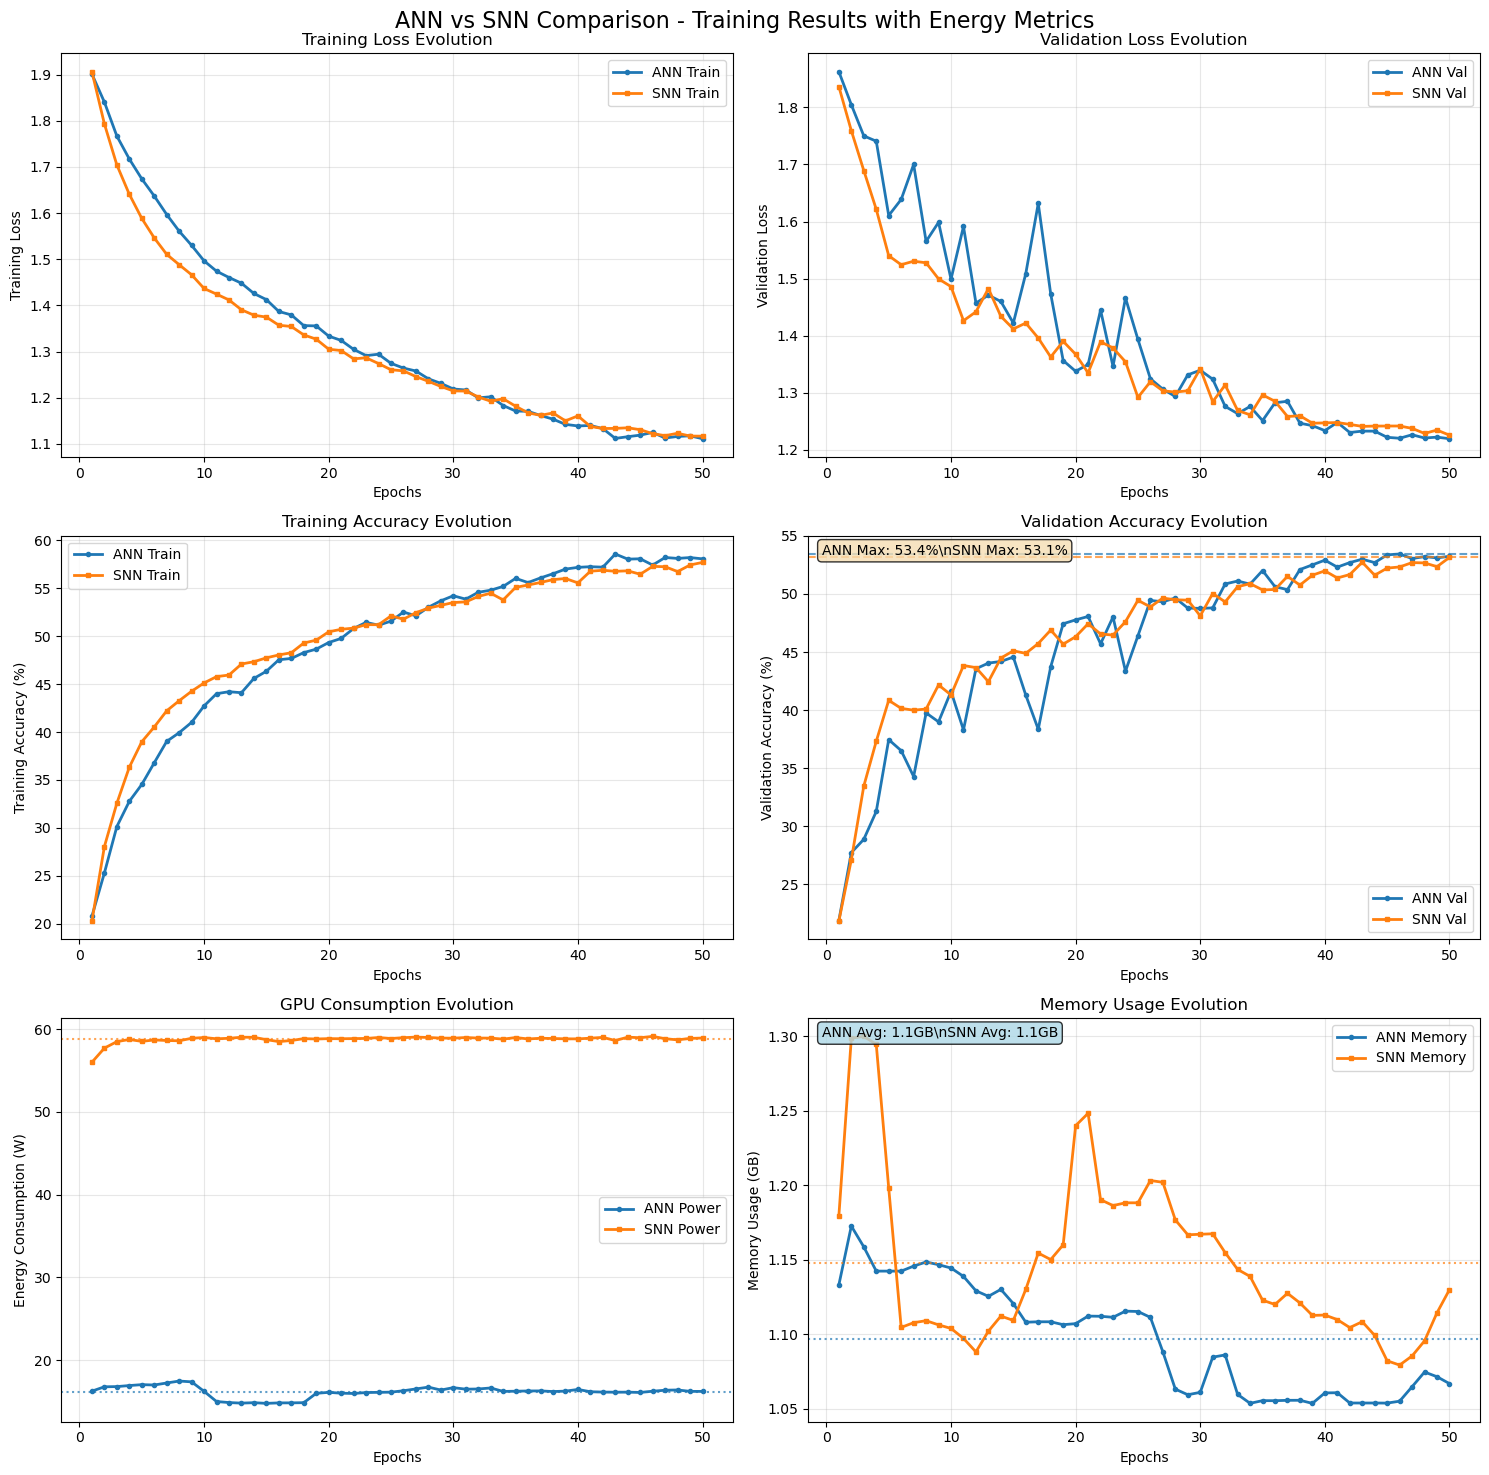

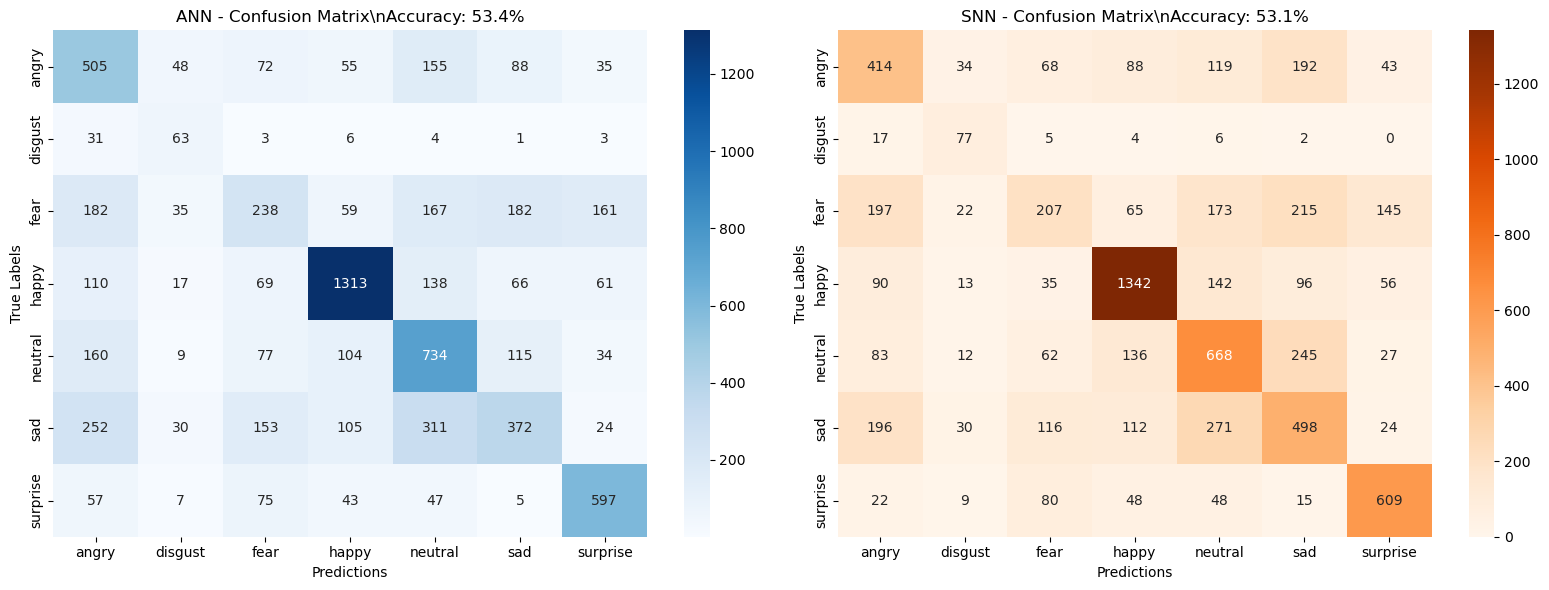

 Charts saved in simple_snn_results/20250824_005442


In [12]:
# =============================================================================
# 10. VISUALIZATIONS
# =============================================================================

def create_comparison_plots(ann_results, snn_results, save_dir):
    """Creates comparison charts with energy metrics"""
    
    epochs = range(1, len(ann_results['train_losses']) + 1)
    snn_epochs = range(1, len(snn_results['train_losses']) + 1)
    
    # Style configuration
    plt.style.use('default')
    colors = {'ann': '#1f77b4', 'snn': '#ff7f0e'}
    
    # Figure creation with an additional line for energy
    fig, axes = plt.subplots(3, 2, figsize=(15, 15))
    fig.suptitle('ANN vs SNN Comparison - Training Results with Energy Metrics', fontsize=16)
    
    # 1. Training losses
    axes[0, 0].plot(epochs, ann_results['train_losses'], 
                   color=colors['ann'], linewidth=2, label='ANN Train', marker='o', markersize=3)
    axes[0, 0].plot(snn_epochs, snn_results['train_losses'], 
                   color=colors['snn'], linewidth=2, label='SNN Train', marker='s', markersize=3)
    axes[0, 0].set_xlabel('Epochs')
    axes[0, 0].set_ylabel('Training Loss')
    axes[0, 0].set_title('Training Loss Evolution')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # 2. Validation losses
    axes[0, 1].plot(epochs, ann_results['val_losses'], 
                   color=colors['ann'], linewidth=2, label='ANN Val', marker='o', markersize=3)
    axes[0, 1].plot(snn_epochs, snn_results['val_losses'], 
                   color=colors['snn'], linewidth=2, label='SNN Val', marker='s', markersize=3)
    axes[0, 1].set_xlabel('Epochs')
    axes[0, 1].set_ylabel('Validation Loss')
    axes[0, 1].set_title('Validation Loss Evolution')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # 3. Training accuracy
    axes[1, 0].plot(epochs, [acc*100 for acc in ann_results['train_accs']], 
                   color=colors['ann'], linewidth=2, label='ANN Train', marker='o', markersize=3)
    axes[1, 0].plot(snn_epochs, [acc*100 for acc in snn_results['train_accs']], 
                   color=colors['snn'], linewidth=2, label='SNN Train', marker='s', markersize=3)
    axes[1, 0].set_xlabel('Epochs')
    axes[1, 0].set_ylabel('Training Accuracy (%)')
    axes[1, 0].set_title('Training Accuracy Evolution')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # 4. Validation accuracy
    axes[1, 1].plot(epochs, [acc*100 for acc in ann_results['val_accs']], 
                   color=colors['ann'], linewidth=2, label='ANN Val', marker='o', markersize=3)
    axes[1, 1].plot(snn_epochs, [acc*100 for acc in snn_results['val_accs']], 
                   color=colors['snn'], linewidth=2, label='SNN Val', marker='s', markersize=3)
    axes[1, 1].set_xlabel('Epochs')
    axes[1, 1].set_ylabel('Validation Accuracy (%)')
    axes[1, 1].set_title('Validation Accuracy Evolution')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    
    # Adding maximum performance annotations
    ann_max_acc = max(ann_results['val_accs']) * 100
    snn_max_acc = max(snn_results['val_accs']) * 100
    
    axes[1, 1].axhline(y=ann_max_acc, color=colors['ann'], linestyle='--', alpha=0.7)
    axes[1, 1].axhline(y=snn_max_acc, color=colors['snn'], linestyle='--', alpha=0.7)
    
    axes[1, 1].text(0.02, 0.98, f'ANN Max: {ann_max_acc:.1f}%\\nSNN Max: {snn_max_acc:.1f}%', 
                   transform=axes[1, 1].transAxes, verticalalignment='top',
                   bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
    
    # 5. NEW: Energy consumption
    if gpu_monitoring and ann_results.get('power_usage') and snn_results.get('power_usage'):
        axes[2, 0].plot(epochs, ann_results['power_usage'], 
                       color=colors['ann'], linewidth=2, label='ANN Power', marker='o', markersize=3)
        axes[2, 0].plot(snn_epochs, snn_results['power_usage'], 
                       color=colors['snn'], linewidth=2, label='SNN Power', marker='s', markersize=3)
        axes[2, 0].set_xlabel('Epochs')
        axes[2, 0].set_ylabel('Energy Consumption (W)')
        axes[2, 0].set_title('GPU Consumption Evolution')
        axes[2, 0].legend()
        axes[2, 0].grid(True, alpha=0.3)
        
        # Adding averages
        ann_avg_power = ann_results.get('avg_power', 0)
        snn_avg_power = snn_results.get('avg_power', 0)
        axes[2, 0].axhline(y=ann_avg_power, color=colors['ann'], linestyle=':', alpha=0.7, label=f'ANN Avg: {ann_avg_power:.1f}W')
        axes[2, 0].axhline(y=snn_avg_power, color=colors['snn'], linestyle=':', alpha=0.7, label=f'SNN Avg: {snn_avg_power:.1f}W')
    else:
        axes[2, 0].text(0.5, 0.5, 'Energy monitoring\\nnot available', 
                       ha='center', va='center', transform=axes[2, 0].transAxes,
                       bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.7))
        axes[2, 0].set_title('Energy Consumption')
    
    # 6. NEW: Memory usage
    if gpu_monitoring and ann_results.get('memory_usage') and snn_results.get('memory_usage'):
        axes[2, 1].plot(epochs, ann_results['memory_usage'], 
                       color=colors['ann'], linewidth=2, label='ANN Memory', marker='o', markersize=3)
        axes[2, 1].plot(snn_epochs, snn_results['memory_usage'], 
                       color=colors['snn'], linewidth=2, label='SNN Memory', marker='s', markersize=3)
        axes[2, 1].set_xlabel('Epochs')
        axes[2, 1].set_ylabel('Memory Usage (GB)')
        axes[2, 1].set_title('Memory Usage Evolution')
        axes[2, 1].legend()
        axes[2, 1].grid(True, alpha=0.3)
        
        # Adding averages
        ann_avg_memory = ann_results.get('avg_memory', 0)
        snn_avg_memory = snn_results.get('avg_memory', 0)
        axes[2, 1].axhline(y=ann_avg_memory, color=colors['ann'], linestyle=':', alpha=0.7)
        axes[2, 1].axhline(y=snn_avg_memory, color=colors['snn'], linestyle=':', alpha=0.7)
        
        # Average annotations
        axes[2, 1].text(0.02, 0.98, f'ANN Avg: {ann_avg_memory:.1f}GB\\nSNN Avg: {snn_avg_memory:.1f}GB', 
                       transform=axes[2, 1].transAxes, verticalalignment='top',
                       bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))
    else:
        axes[2, 1].text(0.5, 0.5, 'Memory monitoring\\nnot available', 
                       ha='center', va='center', transform=axes[2, 1].transAxes,
                       bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.7))
        axes[2, 1].set_title('Memory Usage')
    
    plt.tight_layout()
    plt.savefig(f"{save_dir}/training_comparison.png", dpi=300, bbox_inches='tight')
    plt.show()
    
    return fig

def create_confusion_matrices(ann_results, snn_results, class_names, save_dir):
    """Creates comparative confusion matrices"""
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # ANN confusion matrix
    cm_ann = confusion_matrix(ann_results['final_labels'], ann_results['final_preds'])
    sns.heatmap(cm_ann, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names, ax=ax1)
    ax1.set_title(f'ANN - Confusion Matrix\\nAccuracy: {ann_results["best_val_acc"]*100:.1f}%')
    ax1.set_xlabel('Predictions')
    ax1.set_ylabel('True Labels')
    
    # SNN confusion matrix
    cm_snn = confusion_matrix(snn_results['final_labels'], snn_results['final_preds'])
    sns.heatmap(cm_snn, annot=True, fmt='d', cmap='Oranges',
                xticklabels=class_names, yticklabels=class_names, ax=ax2)
    ax2.set_title(f'SNN - Confusion Matrix\\nAccuracy: {snn_results["best_val_acc"]*100:.1f}%')
    ax2.set_xlabel('Predictions')  
    ax2.set_ylabel('True Labels')
    
    plt.tight_layout()
    plt.savefig(f"{save_dir}/confusion_matrices.png", dpi=300, bbox_inches='tight')
    plt.show()
    
    return fig

# Generating visualizations
print("\n Generating visualizations...")

comparison_fig = create_comparison_plots(ann_results, snn_results, config.experiment_dir)
confusion_fig = create_confusion_matrices(ann_results, snn_results, train_dataset.classes, config.experiment_dir)

print(f" Charts saved in {config.experiment_dir}")

In [13]:
# =============================================================================
# 11. RAPPORTS DÉTAILLÉS
# =============================================================================

print("\n RAPPORTS DE CLASSIFICATION DÉTAILLÉS")
print("-" * 50)

print("\n ANN BASELINE - Classification Report:")
print(classification_report(
    ann_results['final_labels'], 
    ann_results['final_preds'],
    target_names=train_dataset.classes,
    zero_division=0
))

print("\n SNN SIMPLE - Classification Report:")
print(classification_report(
    snn_results['final_labels'], 
    snn_results['final_preds'],
    target_names=train_dataset.classes,
    zero_division=0
))



 RAPPORTS DE CLASSIFICATION DÉTAILLÉS
--------------------------------------------------

 ANN BASELINE - Classification Report:
              precision    recall  f1-score   support

       angry       0.39      0.53      0.45       958
     disgust       0.30      0.57      0.39       111
        fear       0.35      0.23      0.28      1024
       happy       0.78      0.74      0.76      1774
     neutral       0.47      0.60      0.53      1233
         sad       0.45      0.30      0.36      1247
    surprise       0.65      0.72      0.68       831

    accuracy                           0.53      7178
   macro avg       0.48      0.53      0.49      7178
weighted avg       0.53      0.53      0.53      7178


 SNN SIMPLE - Classification Report:
              precision    recall  f1-score   support

       angry       0.41      0.43      0.42       958
     disgust       0.39      0.69      0.50       111
        fear       0.36      0.20      0.26      1024
       happy      

In [17]:
import pandas as pd
pd.set_option('display.max_rows', None)
pd.set_option('display.width', None)

print("\n RAPPORTS DE CLASSIFICATION DÉTAILLÉS")
print("=" * 80)

print("\n🔹 ANN BASELINE - Classification Report:")
ann_report = classification_report(
    ann_results['final_labels'],
    ann_results['final_preds'],
    target_names=train_dataset.classes,
    zero_division=0
)
print(ann_report)

print("\n🔹 SNN SIMPLE - Classification Report:")
snn_report = classification_report(
    snn_results['final_labels'],
    snn_results['final_preds'],
    target_names=train_dataset.classes,
    zero_division=0
)
print(snn_report)


 RAPPORTS DE CLASSIFICATION DÉTAILLÉS

🔹 ANN BASELINE - Classification Report:
              precision    recall  f1-score   support

       angry       0.39      0.53      0.45       958
     disgust       0.30      0.57      0.39       111
        fear       0.35      0.23      0.28      1024
       happy       0.78      0.74      0.76      1774
     neutral       0.47      0.60      0.53      1233
         sad       0.45      0.30      0.36      1247
    surprise       0.65      0.72      0.68       831

    accuracy                           0.53      7178
   macro avg       0.48      0.53      0.49      7178
weighted avg       0.53      0.53      0.53      7178


🔹 SNN SIMPLE - Classification Report:
              precision    recall  f1-score   support

       angry       0.41      0.43      0.42       958
     disgust       0.39      0.69      0.50       111
        fear       0.36      0.20      0.26      1024
       happy       0.75      0.76      0.75      1774
     neutral 

In [ ]:
# =============================================================================
# 12. DIAGNOSTIC ET RECOMMANDATIONS SPÉCIFIQUES
# =============================================================================

print("\n" + "=" * 50)
print(" DIAGNOSTIC ET RECOMMANDATIONS")
print("=" * 50)

def generate_recommendations(ann_acc, snn_acc, imbalance_ratio):
    """Génère des recommandations spécifiques basées sur les performances"""
    
    recommendations = []
    
    # Analyse de la qualité des données
    if ann_acc < 0.25:
        recommendations.extend([
            " CRITIQUE - Qualité des données:",
            "   1. Vérifier les transformations d'image (resize, normalisation)",
            "   2. Inspecter manuellement un échantillon d'images",
            "   3. Vérifier la cohérence des labels",
            "   4. Considérer un nettoyage du dataset",
            f"  5. Ratio de déséquilibre: {imbalance_ratio:.1f}:1 - si > 5, ré-équilibrer",
            ""
        ])
    
    # Analyse des performances SNN
    if snn_acc < 0.15:
        recommendations.extend([
            " CRITIQUE - SNN complètement défaillant:",
            "   1. Réduire num_timesteps à 4-6",
            "   2. Essayer architecture 'ultra_simple'",
            "   3. Vérifier la génération de spikes avec des inputs test",
            "   4. Réduire learning rate SNN à 1e-4",
            "   5. Essayer des neurones IF au lieu de LIF",
            ""
        ])
    elif snn_acc < ann_acc * 0.4:
        recommendations.extend([
            "  WARNING - Gap sévère ANN-SNN:",
            "   1. Ajuster les paramètres LIF (tau=1.0-1.5, threshold=0.8)",
            "   2. Essayer différentes fonctions surrogate (Sigmoid vs ATan)", 
            "   3. Augmenter légèrement le learning rate SNN à 8e-4",
            "   4. Vérifier l'équilibrage temporal des spikes",
            ""
        ])
    elif snn_acc < ann_acc * 0.7:
        recommendations.extend([
            " MODÉRÉ - Gap important mais récupérable:",
            "   1. Fine-tuning des hyperparamètres SNN",
            "   2. Essayer num_timesteps = 12-16",
            "   3. Ajouter une couche convolutive",
            "   4. Expérimenter avec différents optimiseurs",
            ""
        ])
    elif snn_acc < ann_acc * 0.9:
        recommendations.extend([
            " BON - Gap modéré, bonnes bases:",
            "   1. Optimiser l'architecture (plus de profondeur/largeur)",
            "   2. Ajouter des techniques de régularisation avancées",
            "   3. Implémenter l'attention temporelle",
            "   4. Essayer des connexions résiduelles",
            ""
        ])
    else:
        recommendations.extend([
            " EXCELLENT - Performance compétitive:",
            "   1. Prêt pour des architectures plus sophistiquées",
            "   2. Implémenter des techniques d'optimisation neuromorphique",
            "   3. Tester sur d'autres datasets",
            "   4. Optimiser pour l'efficacité énergétique",
            ""
        ])
    
    # Recommandations générales
    if imbalance_ratio > 5:
        recommendations.extend([
            " DONNÉES - Déséquilibre sévère détecté:",
            "   1. Appliquer SMOTE ou over-sampling",
            "   2. Utiliser des loss functions pondérées",
            "   3. Collecter plus de données pour les classes minoritaires",
            ""
        ])
    
    return recommendations

# Génération des recommandations
recommendations = generate_recommendations(ann_best_acc, snn_best_acc, imbalance_ratio)

print(" ANALYSE:")
print(f"   Dataset: {len(train_dataset)} images d'entraînement")
print(f"   Déséquilibre: {imbalance_ratio:.1f}:1")
print(f"   ANN Baseline: {ann_best_acc:.3f} ({ann_best_acc*100:.1f}%)")
print(f"   SNN Simple: {snn_best_acc:.3f} ({snn_best_acc*100:.1f}%)")
print(f"   Ratio Performance: {performance_ratio:.2f}")

print("\n RECOMMANDATIONS SPÉCIFIQUES:")
for rec in recommendations:
    print(rec)


 DIAGNOSTIC ET RECOMMANDATIONS
 ANALYSE:
   Dataset: 28709 images d'entraînement
   Déséquilibre: 16.5:1
   ANN Baseline: 0.534 (53.4%)
   SNN Simple: 0.531 (53.1%)
   Ratio Performance: 0.99

 RECOMMANDATIONS SPÉCIFIQUES:
 EXCELLENT - Performance compétitive:
   1. Prêt pour des architectures plus sophistiquées
   2. Implémenter des techniques d'optimisation neuromorphique
   3. Tester sur d'autres datasets
   4. Optimiser pour l'efficacité énergétique

 DONNÉES - Déséquilibre sévère détecté:
   1. Appliquer SMOTE ou over-sampling
   2. Utiliser des loss functions pondérées
   3. Collecter plus de données pour les classes minoritaires



In [ ]:
# =============================================================================
# 13. SAUVEGARDE DES RÉSULTATS
# =============================================================================

print("\n SAUVEGARDE DES RÉSULTATS...")

# Création du rapport de synthèse (avec métriques énergétiques)
summary_report = {
    'experiment_info': {
        'timestamp': config.timestamp,
        'dataset_path': config.dataset_path,
        'dataset_size': len(train_dataset),
        'num_classes': config.num_classes,
        'class_names': train_dataset.classes,
        'imbalance_ratio': float(imbalance_ratio),
        'gpu_monitoring': gpu_monitoring
    },
    'model_configs': {
        'ann': {
            'architecture': 'BaselineANN',
            'parameters': ann_results['model_info']['total_params'],
            'learning_rate': config.ann_lr
        },
        'snn': {
            'architecture': config.snn_architecture,
            'parameters': snn_results['model_info']['total_params'],
            'learning_rate': config.snn_lr,
            'timesteps': config.snn_timesteps
        }
    },
    'results': {
        'ann_best_accuracy': float(ann_best_acc),
        'snn_best_accuracy': float(snn_best_acc),
        'performance_ratio': float(performance_ratio),
        'ann_best_epoch': int(ann_results['best_epoch']),
        'snn_best_epoch': int(snn_results['best_epoch'])
    },
    'energy_metrics': {},  # Sera rempli si monitoring disponible
    'training_history': {
        'ann': {
            'train_losses': [float(x) for x in ann_results['train_losses']],
            'val_losses': [float(x) for x in ann_results['val_losses']],
            'train_accs': [float(x) for x in ann_results['train_accs']],
            'val_accs': [float(x) for x in ann_results['val_accs']]
        },
        'snn': {
            'train_losses': [float(x) for x in snn_results['train_losses']],
            'val_losses': [float(x) for x in snn_results['val_losses']],
            'train_accs': [float(x) for x in snn_results['train_accs']],
            'val_accs': [float(x) for x in snn_results['val_accs']]
        }
    },
    'recommendations': recommendations
}

# Ajout des métriques énergétiques si disponibles
if gpu_monitoring:
    summary_report['energy_metrics'] = {
        'ann': {
            'avg_power_watts': float(ann_results.get('avg_power', 0)),
            'max_power_watts': float(ann_results.get('max_power', 0)),
            'avg_memory_gb': float(ann_results.get('avg_memory', 0)),
            'power_history': [float(x) for x in ann_results.get('power_usage', [])],
            'memory_history': [float(x) for x in ann_results.get('memory_usage', [])]
        },
        'snn': {
            'avg_power_watts': float(snn_results.get('avg_power', 0)),
            'max_power_watts': float(snn_results.get('max_power', 0)),
            'avg_memory_gb': float(snn_results.get('avg_memory', 0)),
            'power_history': [float(x) for x in snn_results.get('power_usage', [])],
            'memory_history': [float(x) for x in snn_results.get('memory_usage', [])]
        },
        'efficiency': {
            'ann_accuracy_per_watt': float(ann_efficiency) if 'ann_efficiency' in locals() else 0,
            'snn_accuracy_per_watt': float(snn_efficiency) if 'snn_efficiency' in locals() else 0,
            'efficiency_ratio_snn_vs_ann': float(efficiency_ratio) if 'efficiency_ratio' in locals() else 0
        }
    }

# Sauvegarde du rapport JSON
with open(f"{config.experiment_dir}/summary_report.json", 'w') as f:
    json.dump(summary_report, f, indent=2)

# Sauvegarde des résultats détaillés
torch.save({
    'ann_results': ann_results,
    'snn_results': snn_results,
    'config': config_dict,
    'summary': summary_report
}, f"{config.experiment_dir}/detailed_results.pth")

print(f" Rapport de synthèse: {config.experiment_dir}/summary_report.json")
print(f" Résultats détaillés: {config.experiment_dir}/detailed_results.pth")
print(f" Graphiques: {config.experiment_dir}/training_comparison.png")
print(f" Matrices de confusion: {config.experiment_dir}/confusion_matrices.png")

# %%
# =============================================================================
# 14. RÉSUMÉ FINAL
# =============================================================================

print("\n" + "=" * 60)
print(" RÉSUMÉ DE L'EXPÉRIENCE SNN")
print("=" * 60)

print(f" Expérience terminée le: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f" Résultats sauvés dans: {config.experiment_dir}")

print("\n PERFORMANCES FINALES:")
print(f"   ANN Baseline:  {ann_best_acc*100:5.1f}% (époque {ann_results['best_epoch']+1})")
print(f"    SNN Simple:    {snn_best_acc*100:5.1f}% (époque {snn_results['best_epoch']+1})")
print(f"   Ratio SNN/ANN: {performance_ratio:5.2f}")

print(f"\n DONNÉES:")
print(f"   Images d'entraînement: {len(train_dataset):,}")
print(f"   Images de test:        {len(test_dataset):,}")
print(f"   Classes:              {len(train_dataset.classes)}")
print(f"   Déséquilibre:         {imbalance_ratio:.1f}:1")

if ann_best_acc > 0.35 and snn_best_acc > 0.25:
    print("\n SUCCÈS - Les modèles ont des performances exploitables !")
    print("   Prochaine étape: Optimisation et complexification")
elif ann_best_acc > 0.35:
    print("\n⚡ MITIGÉ - ANN fonctionne, SNN à optimiser")
    print("   Prochaine étape: Debug et amélioration du SNN")
else:
    print("\n PROBLÈME - Performances faibles sur les deux modèles")
    print("   Prochaine étape: Analyser et améliorer la qualité des données")

print(f"\n Consultez les recommandations spécifiques ci-dessus")
print(f" Rapport complet disponible dans {config.experiment_dir}")

print("\n Expérience terminée avec succès !")

# %%


💾 SAUVEGARDE DES RÉSULTATS...
 Rapport de synthèse: simple_snn_results/20250824_005442/summary_report.json
 Résultats détaillés: simple_snn_results/20250824_005442/detailed_results.pth
 Graphiques: simple_snn_results/20250824_005442/training_comparison.png
 Matrices de confusion: simple_snn_results/20250824_005442/confusion_matrices.png

 RÉSUMÉ DE L'EXPÉRIENCE SNN
 Expérience terminée le: 2025-08-24 01:24:06
📁 Résultats sauvés dans: simple_snn_results/20250824_005442

 PERFORMANCES FINALES:
   ANN Baseline:   53.4% (époque 46)
    SNN Simple:     53.1% (époque 50)
   Ratio SNN/ANN:  0.99

 DONNÉES:
   Images d'entraînement: 28,709
   Images de test:        7,178
   Classes:              7
   Déséquilibre:         16.5:1

 SUCCÈS - Les modèles ont des performances exploitables !
   Prochaine étape: Optimisation et complexification

 Consultez les recommandations spécifiques ci-dessus
 Rapport complet disponible dans simple_snn_results/20250824_005442

 Expérience terminée avec succès 

# TEST AVEC LES IMAGES

In [3]:
#!/usr/bin/env python3
"""
TERMINAL STYLE IMAGE TESTING
=============================

Script to test CNN vs SNN models with terminal-style output like your reference image.
"""

import torch
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import os
from pathlib import Path

# Import your models
try:
    from snn_simple2 import (
        create_simple_snn,
        create_baseline_ann, 
        reset_snn_state
    )
    print(" Models imported successfully")
except ImportError as e:
    print(f" Import error: {e}")
    exit(1)


 Models imported successfully


 TERMINAL STYLE CNN vs SNN TEST
 PyTorch available
 CUDA available: NVIDIA GeForce RTX 3050 6GB Laptop GPU

 TERMINAL STYLE TEST MENU
1. Test a specific image
2. Test a random image from dataset
3. Exit
 Device: cuda
 Image: /home/dieudo/Projects/Project_Neuro/Fer_Neuromorphique/data/test/sad/PrivateTest_2552088.jpg
  True class detected: Sad
 Image loaded: torch.Size([1, 1, 48, 48])

🔧 Creating models...
🔧 Création du modèle ANN baseline...
✅ Modèle ANN baseline créé
   Paramètres totaux: 102,119
   Paramètres entraînables: 102,119
   Classes: 7
🔧 Création du modèle SNN (simple)...
 Modèle SNN créé avec succès
   Architecture: simple
   Paramètres totaux: 430,240
   Paramètres entraînables: 430,240
   Classes: 7
   Pas temporels: 8
   ⚡ Paramètres tau: tous > 1.0 (SpikingJelly compatible)
 CNN model loaded: 0.534
 SNN model loaded: 0.531

 Making predictions...

 RESULTS:
   True class: Sad
   CNN: Sad (31.8%)
   SNN: Sad (38.1%)
   Both models agree!


/tmp/ipykernel_7365/3566076133.py:64: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(ann_path, map_location=device)
/tmp/ipykernel_7365/3566076133.py:

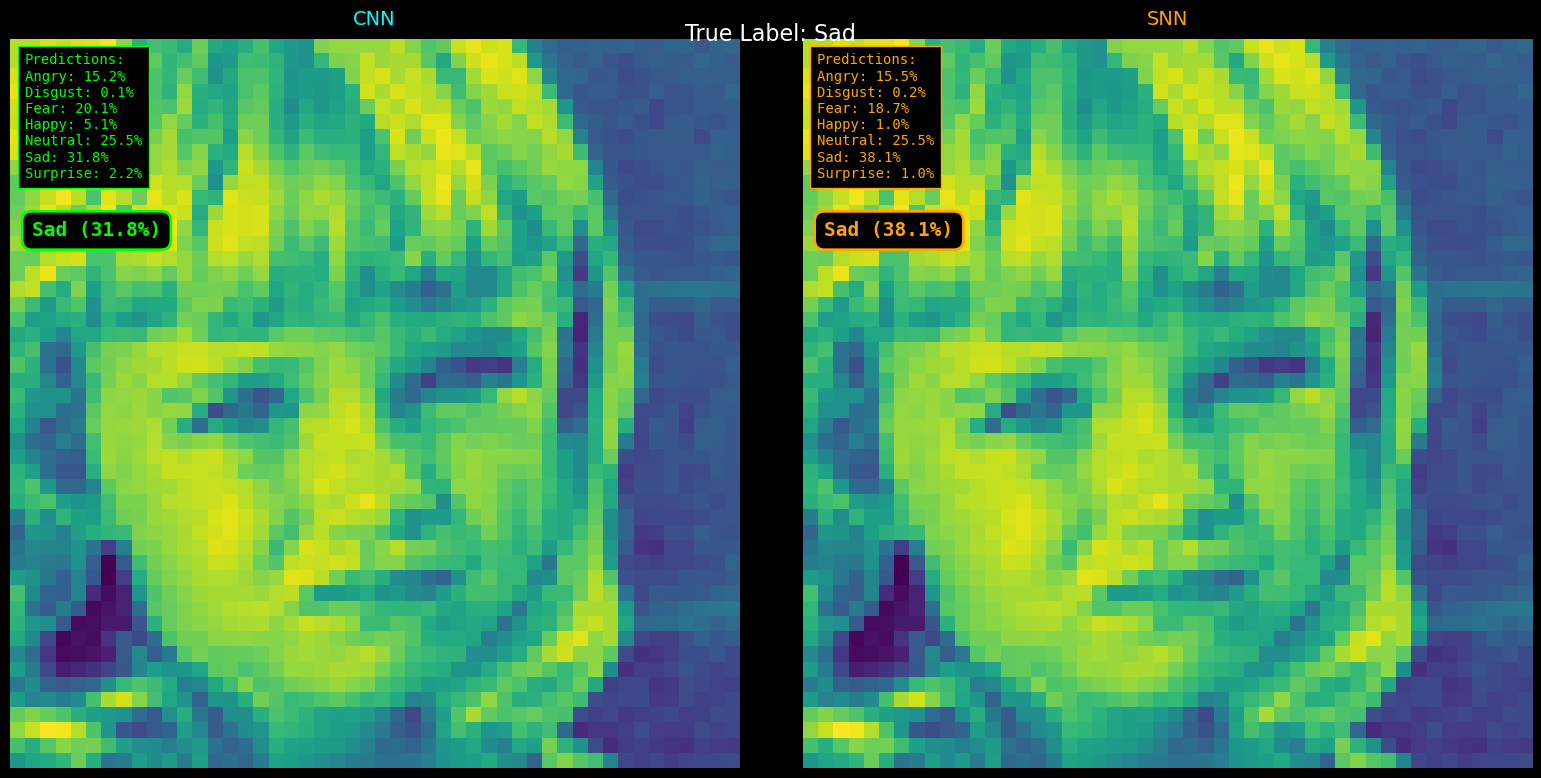

 Result saved: terminal_style_result.png
 Goodbye!


In [ ]:

def load_and_test_single_image(image_path, models_dir="simple_snn_results"):
    """
    Tests a single image with CNN and SNN models in terminal style
    
    Args:
        image_path: Path to the image to test
        models_dir: Directory containing trained models
    """
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    class_names = ['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']
    
    print(f" Device: {device}")
    print(f" Image: {image_path}")
    
    # Extract true class from path if possible
    true_class = None
    try:
        path_parts = Path(image_path).parts
        for part in path_parts:
            if part.capitalize() in class_names:
                true_class = part.capitalize()
                break
        if true_class:
            print(f"  True class detected: {true_class}")
    except:
        pass
    
    # Image transformations
    transform = transforms.Compose([
        transforms.Grayscale(num_output_channels=1),
        transforms.Resize((48, 48)),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])
    
    # Load image
    try:
        image = Image.open(image_path)
        image_tensor = transform(image).unsqueeze(0).to(device)
        print(f" Image loaded: {image_tensor.shape}")
    except Exception as e:
        print(f" Image loading error: {e}")
        return
    
    # Create models
    print("\n Creating models...")
    ann_model = create_baseline_ann(num_classes=7)
    snn_model = create_simple_snn("simple", num_classes=7, num_timesteps=8)
    
    ann_model = ann_model.to(device)
    snn_model = snn_model.to(device)
    
    # Find and load trained models
    results_dir = Path(models_dir)
    if results_dir.exists():
        experiment_dirs = [d for d in results_dir.iterdir() if d.is_dir()]
        if experiment_dirs:
            latest_dir = max(experiment_dirs, key=lambda x: x.stat().st_mtime)
            
            # Load CNN
            ann_path = latest_dir / "best_ann_model.pth"
            if ann_path.exists():
                checkpoint = torch.load(ann_path, map_location=device)
                ann_model.load_state_dict(checkpoint['model_state_dict'])
                print(f" CNN model loaded: {checkpoint.get('best_val_acc', 0):.3f}")
            else:
                print(" CNN model not found - using random model")
            
            # Load SNN
            snn_path = latest_dir / "best_snn_model.pth" 
            if snn_path.exists():
                checkpoint = torch.load(snn_path, map_location=device)
                snn_model.load_state_dict(checkpoint['model_state_dict'])
                print(f" SNN model loaded: {checkpoint.get('best_val_acc', 0):.3f}")
            else:
                print("  SNN model not found - using random model")
        else:
            print("  No experiment directory found - using random models")
    else:
        print("  Results directory not found - using random models")
    
    # Set to evaluation mode
    ann_model.eval()
    snn_model.eval()
    
    # Make predictions
    print("\n Making predictions...")
    with torch.no_grad():
        # CNN prediction
        ann_logits = ann_model(image_tensor)
        ann_probs = torch.softmax(ann_logits, dim=1)
        ann_pred = torch.argmax(ann_probs, dim=1).item()
        ann_confidence = torch.max(ann_probs, dim=1)[0].item()
        
        # SNN prediction
        reset_snn_state(snn_model)
        snn_logits = snn_model(image_tensor)
        snn_probs = torch.softmax(snn_logits, dim=1)
        snn_pred = torch.argmax(snn_probs, dim=1).item()
        snn_confidence = torch.max(snn_probs, dim=1)[0].item()
    
    # Display results
    print(f"\n RESULTS:")
    if true_class:
        print(f"   True class: {true_class}")
    print(f"   CNN: {class_names[ann_pred]} ({ann_confidence:.1%})")
    print(f"   SNN: {class_names[snn_pred]} ({snn_confidence:.1%})")
    
    if ann_pred == snn_pred:
        print(f"   Both models agree!")
    else:
        print(f"    Models disagree")
    
    # Create terminal-style visualization
    create_terminal_style_visualization(
        image, image_tensor, true_class,
        ann_pred, ann_confidence, ann_probs,
        snn_pred, snn_confidence, snn_probs,
        class_names
    )

def create_terminal_style_visualization(original_image, tensor_image, true_class,
                                      ann_pred, ann_conf, ann_probs,
                                      snn_pred, snn_conf, snn_probs, class_names):
    """Creates terminal-style visualization like your reference image"""
    
    # Prepare image for display
    img_display = tensor_image.squeeze().cpu().numpy()
    img_display = (img_display + 1) / 2  # Denormalize [-1,1] -> [0,1]
    
    # Create figure with black background
    plt.style.use('dark_background')
    fig, axes = plt.subplots(1, 2, figsize=(16, 8))
    fig.patch.set_facecolor('black')
    
    # Main title with true class (if available)
    if true_class:
        fig.suptitle(f"True Label: {true_class}", fontsize=16, color='white', y=0.95)
    else:
        fig.suptitle("CNN vs SNN Comparison", fontsize=16, color='white', y=0.95)
    
    # Get probabilities as numpy arrays
    cnn_probs_np = ann_probs.squeeze().cpu().numpy()
    snn_probs_np = snn_probs.squeeze().cpu().numpy()
    
    # Left panel: CNN
    axes[0].imshow(img_display, cmap='viridis', aspect='equal')

    # Create terminal-style probability text for CNN
    prob_text = "Predictions:\n"
    for i, (name, prob) in enumerate(zip(class_names, cnn_probs_np)):
        prob_text += f"{name}: {prob*100:.1f}%\n"
    
    # Add text box at top with terminal style
    axes[0].text(0.02, 0.98, prob_text.strip(), 
                transform=axes[0].transAxes, fontsize=10,
                verticalalignment='top', color='lime',
                bbox=dict(boxstyle='square,pad=0.5', facecolor='black', 
                         edgecolor='lime', linewidth=1),
                fontfamily='monospace')
    
    # Add prediction box in center like your reference
    pred_text = f"{class_names[ann_pred]} ({ann_conf:.1%})"
    axes[0].text(0.03, 0.75, pred_text, 
                transform=axes[0].transAxes, fontsize=14,
                #horizontalalignment='center', 
                verticalalignment='top',
                color='lime', fontweight='bold',
                bbox=dict(boxstyle='round,pad=0.5', facecolor='black', 
                         edgecolor='lime', linewidth=2),
                fontfamily='monospace')
    
    axes[0].set_title("CNN", color='cyan', fontsize=14, pad=10)
    axes[0].axis('off')
    
    # Right panel: SNN
    axes[1].imshow(img_display, cmap='viridis', aspect='equal')

    # Create terminal-style probability text for SNN
    prob_text = "Predictions:\n"
    for i, (name, prob) in enumerate(zip(class_names, snn_probs_np)):
        prob_text += f"{name}: {prob*100:.1f}%\n"
    
    # Add text box at top with terminal style
    axes[1].text(0.02, 0.98, prob_text.strip(), 
                transform=axes[1].transAxes, fontsize=10,
                verticalalignment='top', color='orange',
                bbox=dict(boxstyle='square,pad=0.5', facecolor='black', 
                         edgecolor='orange', linewidth=1),
                fontfamily='monospace')
    
    # Add prediction box in center
    pred_text = f"{class_names[snn_pred]} ({snn_conf:.1%})"
    axes[1].text(0.03, 0.75, pred_text, 
                transform=axes[1].transAxes, fontsize=14,
                verticalalignment='top', 
                #horizontalalignment='center',
                color='orange', fontweight='bold',
                bbox=dict(boxstyle='round,pad=0.5', facecolor='black', 
                         edgecolor='orange', linewidth=2),
                fontfamily='monospace')
    
    axes[1].set_title("SNN", color='orange', fontsize=14, pad=10)
    axes[1].axis('off')
    
    plt.tight_layout()
    plt.savefig("terminal_style_result.png", dpi=300, bbox_inches='tight', 
                facecolor="blue", edgecolor='none')
    plt.show()
    
    print(f" Result saved: terminal_style_result.png")

def test_random_from_dataset(dataset_path="/home/dieudo/Projects/Project_Neuro/Fer_Neuromorphique/data"):
    """Tests a random image from the dataset"""
    
    test_dir = Path(dataset_path) / "test"
    if not test_dir.exists():
        print(f" Test directory not found: {test_dir}")
        return
    
    # Find all images
    image_extensions = ['.jpg', '.jpeg', '.png', '.bmp']
    all_images = []
    
    for class_dir in test_dir.iterdir():
        if class_dir.is_dir():
            for img_path in class_dir.iterdir():
                if img_path.suffix.lower() in image_extensions:
                    all_images.append(img_path)
    
    if not all_images:
        print(f" No images found in {test_dir}")
        return
    
    # Choose a random image
    random_image = np.random.choice(all_images)
    true_class = random_image.parent.name
    
    print(f" Random image selected:")
    print(f"   File: {random_image.name}")
    print(f"   True class: {true_class}")
    
    # Test the image
    load_and_test_single_image(str(random_image))

def interactive_menu():
    """Interactive menu to choose test type"""
    
    print("\n TERMINAL STYLE TEST MENU")
    print("=" * 35)
    print("1. Test a specific image")
    print("2. Test a random image from dataset")
    print("3. Exit")
    
    while True:
        try:
            choice = input("\nYour choice (1-3): ").strip()
            
            if choice == '1':
                img_path = input("Image path: ").strip()
                if os.path.exists(img_path):
                    load_and_test_single_image(img_path)
                else:
                    print(" File not found")
                    
            elif choice == '2':
                test_random_from_dataset()
                
            elif choice == '3':
                print(" Goodbye!")
                break
                
            else:
                print(" Invalid choice")
                
        except KeyboardInterrupt:
            print("\n Interrupted by user")
            break
        except Exception as e:
            print(f" Error: {e}")

if __name__ == "__main__":
    print(" TERMINAL STYLE CNN vs SNN TEST")
    print("=" * 40)
    
    # Check that modules are available
    try:
        # Quick import test
        test_tensor = torch.randn(1, 1, 48, 48)
        print(" PyTorch available")
        
        # Check CUDA
        if torch.cuda.is_available():
            print(f" CUDA available: {torch.cuda.get_device_name()}")
        else:
            print("  CUDA not available, using CPU")
            
        # Interactive menu
        interactive_menu()
        
    except Exception as e:
        print(f" Initialization error: {e}")
        import traceback
        traceback.print_exc()